We download what we need from Dropbox: the folder with the **datasets**, the **utils** folder and the model previously trained using the settings in this file. The model was saved so that the network did not have to be re-trained each time the file was opened. Finally we download the `nflows` package.

In [ ]:
!mkdir utils
!mkdir data
!mkdir modelli
!mkdir figures
!wget --output-document=./utils/model.py https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f&dl=0
!wget --output-document=./utils/our_classes.py https://www.dropbox.com/scl/fi/w8sth2i67t26agcvk8nxt/our_classes.py?rlkey=zdl86xxnogw50didjh7b3isix&dl=0
!wget --output-document=./data/dataset_piccolo.txt https://www.dropbox.com/scl/fi/1m1o6kdbeyd6sid8yuw8q/dataset_piccolo.txt?rlkey=hl8xvtrqj3mch3kjzjegw3wns&dl=0
!wget --output-document=./data/dataset.txt https://www.dropbox.com/scl/fi/wsw8e5uitd50tbjactzl3/dataset.txt?rlkey=arv1nh6dpwg1ipmehf5cvx9y5&dl=0
!wget --output-document=./data/test_dataset.txt https://www.dropbox.com/scl/fi/jhkucfrge74eu65bf5iqy/test_dataset.txt?rlkey=wjgg3rd72t3u47rr0ex8tbwj6&dl=0
!wget --output-document=./modelli/epoch=300modello-N_iter4-N_features32-N_BS32-epochs301-lr0.004-val_loss1000.pth https://www.dropbox.com/scl/fi/h52rsf7vm04bhmw15ba4d/epoch-300modello-N_iter4-N_features32-N_BS32-epochs301-lr0.004-val_loss1000.pth?rlkey=jdo6fb2xhbkkay11u9du2udky&dl=0

!pip install nflows

--2024-03-05 11:07:21--  https://www.dropbox.com/scl/fi/idpfpiq94fs1iop2hplhw/model.py?rlkey=pm9i9oqaf224moneg1pkw192f
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3719f92842cb5a84ad03c5eb08.dl.dropboxusercontent.com/cd/0/inline/COib-0a_QCq4INR9lcmPe4McMLt2kIVe7h1I6IV5Bpx6fdst2Ocsf_6KS3AmkMvgh3BukYq6TJRHINAT8OijahCNHHoWgS1Cza7AZs9oIafOOTJ59M_klS2ozHW_DwgX3yqhwlntWYceXAsIPw0Tzv7T/file# [following]
--2024-03-05 11:07:24--  https://uc3719f92842cb5a84ad03c5eb08.dl.dropboxusercontent.com/cd/0/inline/COib-0a_QCq4INR9lcmPe4McMLt2kIVe7h1I6IV5Bpx6fdst2Ocsf_6KS3AmkMvgh3BukYq6TJRHINAT8OijahCNHHoWgS1Cza7AZs9oIafOOTJ59M_klS2ozHW_DwgX3yqhwlntWYceXAsIPw0Tzv7T/file
Resolving uc3719f92842cb5a84ad03c5eb08.dl.dropboxusercontent.com (uc3719f92842cb5a84ad03c5eb08.dl.dropboxusercontent.com)... 162.125.65.15, 2620:10

In [ ]:
import torch
from tqdm import tqdm

from utils.model import model_definer
from utils.our_classes import Compressor
from utils.our_classes import Preprocessor

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os import stat
import time

The original data has 24 features, we created a dictionary to contain the names and units of measurement for each of them.

In [ ]:
labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
unit_measure = {
    0: "GeV",
    1: "arb.",
    2: "rad.",
    3: "GeV",
    4: "",
    5: "GeV",
    6: "GeV",
    7: "GeV",
    8: "GeV",
    9: "GeV",
    10: "GeV",
    11: "GeV",
    12: "",
    13: "",
    14: "",
    15: "",
    16: "",
    17: "",
    18: "",
    19: "GeV",
    20: "GeV",
    21: "GeV",
    22: "",
    23: "",
}
num_features = len(labels_map)

*Training*, *validation* and *test* datasets are imported.<br>
For simplicity and to make calculations faster we have limited ourselves to the first four features and on the number of events, mainly to avoid running out of GPU memory.<br>
The number of events considered before and after the reduction is printed, together with the 100th event, as an example.

In [ ]:
x = np.loadtxt("data/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("data/dataset.txt", delimiter=',')
xtest_all = np.loadtxt("data/test_dataset.txt", delimiter=',')

L=len(x)
print('Number of events in all the training dataset = {}\n'.format(L))

x = x[:int(L/2),:]
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]
xtest_all = xtest_all[:,0:num_features]

print('Events = {}\n'.format(len(x)))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

Number of events in all the training dataset = 472827

Events = 236413

attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



Here a preprocessing procedure is applied to the input data, using the `forward` method of the `Preprocessor` class defined by us.<br>
We apply the logarithm on $p_T$ and on $m$, after shifting the data to ensure that they were far from divergence. Then we bring all data to zero mean and unit variance with `StandardScaler`. Finally we apply the `QuantileTransformer` to bring $\eta$ and $\phi$ into a normal distribution, this last transformation is particularly suitable for training of angular distributions. The `preprocessor_settings` dictionary is created to contain this information.

We define a preprocessor for both the training and validation data, so we will do the inverse transformation by calling the `backward` method.<br>
The preprocessed data is brought to the GPU, where the flow works.

In [ ]:
preprocessor_settings = {'index_log':([0,3]), 'range_quantile':([1,2]), 'n_quantiles':10000}

x_preprocessor = Preprocessor(preprocessor_settings)
xval_preprocessor = Preprocessor(preprocessor_settings)

xtr = x_preprocessor.forward(x)
xtrval = xval_preprocessor.forward(xval)

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Below we report the plot for the distributions of the original and preprocessed data.

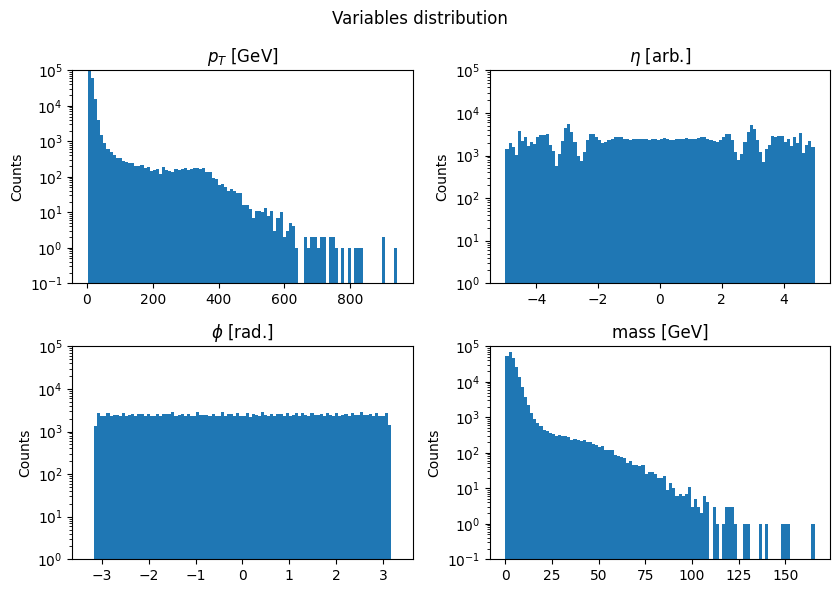

In [ ]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1e-1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

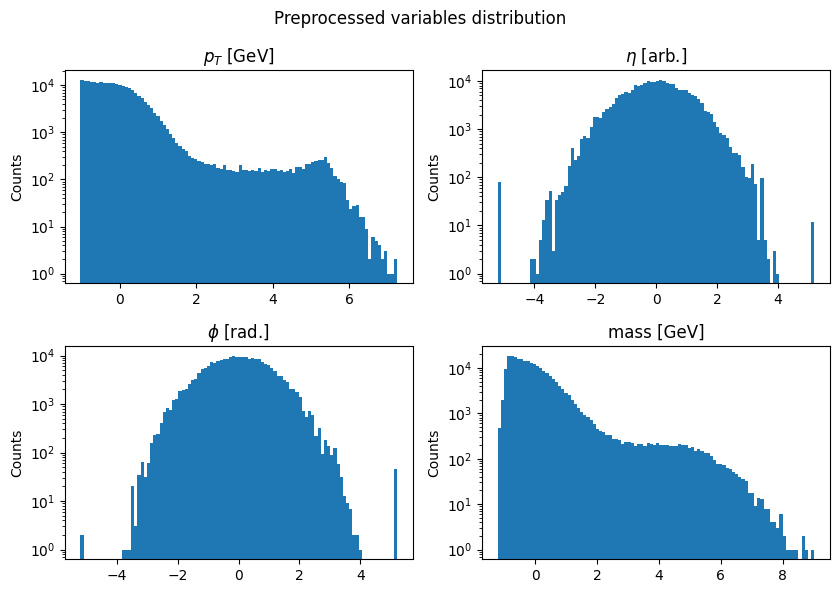

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Preprocessed variables distribution")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")
axs[0, 0].set_ylim(1e-1,10e4)

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")
axs[0, 1].sharey(axs[0,0])

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")
axs[1, 0].sharey(axs[0,0])

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")
axs[1, 1].sharey(axs[0,0])

plt.tight_layout()
plt.show()

fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)

Now we deal with the training, the parameters chosen for the model are shown below. Since the time needed to train this model was very long, it was trained on [Kaggle](https://www.kaggle.com/), where background execution is possible. The results are given in the document [link], as well as the loss plot.




In [ ]:
num_iterations = 4
hidden_features = 32
initial_lr=0.004
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)

Num. iterations = 4, Num. hidden_features = 32, Num. trainable parameters = 18592


In [ ]:
epochs = 301
batch_size = 32
val_batch_size = 10000
delta = 3

counter = 0
loss_values = []
best_val_loss = 10000
loss_validation = []
start = time.time()
for i in range(epochs):
  epoch_loss = 0
  for j in tqdm(range(0,len(xt),batch_size)):
    x_batch = xt[j:j+batch_size]
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x_batch).mean()
    loss.backward()
    optimizer.step()
    epoch_loss += loss.cpu().detach()

  for param_group in optimizer.param_groups:
    lr = param_group['lr']
  epoch_loss /= (len(xt)//batch_size)
  scheduler.step(metrics=epoch_loss)
  loss_values.append(epoch_loss)

  with torch.no_grad():
    val_loss = 0
    for k in range(0, len(xval),val_batch_size):
      x_batch = xval[j:j+val_batch_size]
      loss_val = -flow.log_prob(inputs=xval).mean().cpu()
      val_loss += loss_val
    val_loss /= (len(xval)//val_batch_size)
    loss_validation.append(val_loss)
    if abs(val_loss-epoch_loss) > delta:
      counter += 1
      print('counter=',counter)
      if counter > 10:
        print('Early stopped')
        break
    print('Epoch: {}, Training loss = {}, Validation loss = {}, Learning rate = {}'.format(i,epoch_loss,val_loss,lr))
  if i % 5 == 0:
    nome='epoch='+str(i)+'modello-N_iter'+str(num_iterations)+'-N_features'+str(hidden_features)+'-N_BS'+str(batch_size)+'-epochs'+str(epochs)+'-lr'+str(initial_lr)+'.pth'
    torch.save(flow.state_dict(), 'modelli/'+nome)
    print('Model saved')


end = time.time()
print('Time = {:0.05} s'.format(end-start))

100%|██████████| 24/24 [00:00<00:00, 32.64it/s]


Epoch: 0, Training loss = 2.905674457550049, Validation loss = 2.9306302070617676, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 69.66it/s]


Epoch: 1, Training loss = 2.9050698280334473, Validation loss = 2.9345269203186035, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.88it/s]


Epoch: 2, Training loss = 2.9044525623321533, Validation loss = 2.938819169998169, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.84it/s]


Epoch: 3, Training loss = 2.9040791988372803, Validation loss = 2.944936752319336, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 44.78it/s]


Epoch: 4, Training loss = 2.9040002822875977, Validation loss = 2.955144166946411, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 40.56it/s]


Epoch: 5, Training loss = 2.9039194583892822, Validation loss = 2.9623634815216064, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 70.24it/s]


Epoch: 6, Training loss = 2.9023454189300537, Validation loss = 2.9560935497283936, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 71.06it/s]


Epoch: 7, Training loss = 2.9002573490142822, Validation loss = 2.950681209564209, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 76.06it/s]


Epoch: 8, Training loss = 2.8997106552124023, Validation loss = 2.9517791271209717, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.30it/s]


Epoch: 9, Training loss = 2.8990554809570312, Validation loss = 2.9520347118377686, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 63.48it/s]


Epoch: 10, Training loss = 2.89843487739563, Validation loss = 2.9518442153930664, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 45.77it/s]


Epoch: 11, Training loss = 2.897874593734741, Validation loss = 2.951425075531006, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 74.10it/s]


Epoch: 12, Training loss = 2.8972971439361572, Validation loss = 2.9513769149780273, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 68.08it/s]


Epoch: 13, Training loss = 2.896623373031616, Validation loss = 2.9509470462799072, Learning rate = 0.001


100%|██████████| 24/24 [00:00<00:00, 73.34it/s]


KeyboardInterrupt: 

The cell below allows us to import the model previously trained and saved via Pytorch, following this [tutorial](https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html).

In [ ]:
num_iterations = 4
hidden_features = 32
initial_lr=0.004
flow, optimizer, scheduler = model_definer(num_features=num_features, num_iterations=num_iterations, hidden_features=hidden_features, patience = 10, factor = 0.5, min_lr = 1e-6, initial_lr = initial_lr)
flow.load_state_dict(torch.load('modelli/epoch=300modello-N_iter4-N_features32-N_BS32-epochs301-lr0.004-val_loss1000.pth'))
flow.eval()

Num. iterations = 4, Num. hidden_features = 32, Num. trainable parameters = 18592


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): RandomPermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=32, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=32, out_features=32, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=32, out_features=8, bias=True)
        )
      )
      (2): RandomPermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=4, out_features=32, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
             

We now report an example of application of the flow: after sending our data into a normal distribution we can use the flow to generate new data, which will have the same distribution of the original data. This is the sampling procedure. The comparison between the original data and the generated data are an indication of how much the model was able to learn in the training. <br><br>
In order to compare the new data with the original ones we must apply the preprocessing transformation in reverse, so we use the `backward` method. The figure below shows the two distributions compared.

In [ ]:
sample_batch_size = 100000

sample = np.zeros(x.shape)
for t in range(0,len(sample), sample_batch_size):
  sample[t:t+sample_batch_size] = flow.sample(len(sample[t:t+sample_batch_size])).cpu().detach().numpy()
sample = x_preprocessor.backward(sample)

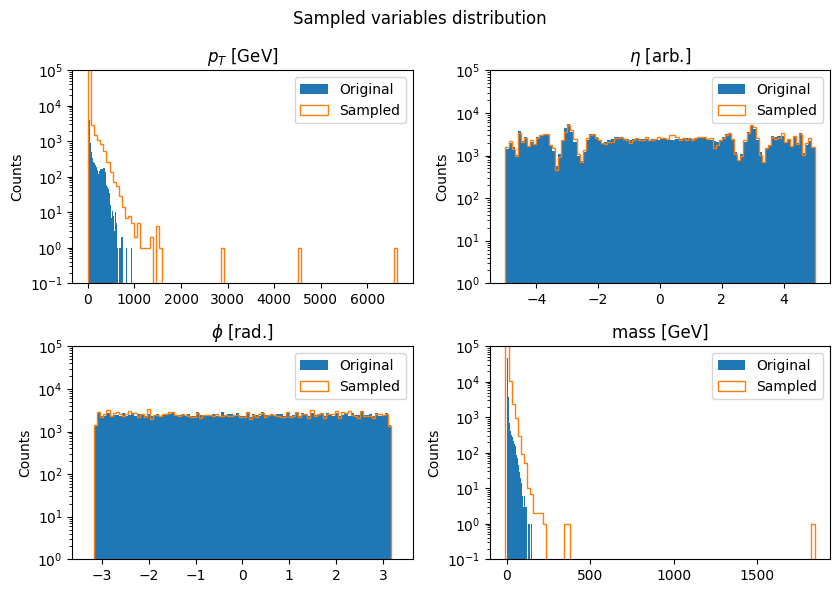

In [ ]:
fig,axs = plt.subplots(2, 2,figsize=(8.5,6))
fig.suptitle("Sampled variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, label='Original')
axs[0, 0].hist(sample[:,0],bins=n_bins,histtype='step', label='Sampled')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend()
axs[0, 0].set_ylim(1e-1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5), label='Original')
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step', label='Sampled')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend()
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30), label='Original')
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step', label='Sampled')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, label='Original')
axs[1, 1].hist(sample[:,3],bins=n_bins, label='Sampled',histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_sample_model2.pdf',dpi=190)

To achieve lossy compression we created the `Compressor` class, it has two methods: one for compression and one for decompression. <br>The idea we want to implement is described by the following lines:
```
training
gaus = flow(data)
unif = erf(gaus)
unif' = unif * 2**N
unif'' = int(unif')
comp = unif''/2**N
gaus' = erfinv(comp)
data' = flow^-1(gaus') ==? data
```
Through the flow that we have learned we bring the original data into gaussian distributions, subsequently we can obtain uniform distributions using the `erf` function. Compression consists of casting as integer the data of the uniform distribution, after rescaling the unit interval of the uniform distribution by a factor of `2**N`, where `N` is the number of compression bits used. We can now get the decompressed data using the `decompress` method.<br>
To make sure that the `erfinv` function does not return infinite numbers we use Scikit-learn's `MaxAbsScaler` in the `compress` method, rescaling everything to $3\sigma$. In the `decompress` method we apply the inverse transformation.<br><br>
Note that in this cell the number of compression bits used is chosen, $N$ enters as an attribute of the Compressor class.

In [ ]:
compression_batch_size = 10000

x_compressed= np.zeros(x.shape)
x_decompressed= np.zeros(x.shape)
gaus= np.zeros(x.shape)
unif= np.zeros(x.shape)
gaus_post = np.zeros(x.shape)

for t in range(0,len(xt), compression_batch_size):
  x_compressor = Compressor(flow=flow, N=13, limit=3)
  x_compressed[t:t+compression_batch_size], gaus[t:t+compression_batch_size], unif[t:t+compression_batch_size] = x_compressor.compress(xt[t:t+compression_batch_size])
  x_decompressed[t:t+compression_batch_size], gaus_post[t:t+compression_batch_size] = x_compressor.decompress(x_compressed[t:t+compression_batch_size])

x_compressed = x_compressed.astype(int)
x_decompressed = x_preprocessor.backward(x_decompressed)

We now present the plots of the Gaussian distributions returned by the flow, when it acts on the data. In the off-diagonal elements, the distributions are reported as a function of the others, via `scatter plot`.<br>
In addition, tests on the normality of the Gaussians are also performed, using [`scipy.stats.normaltest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html).

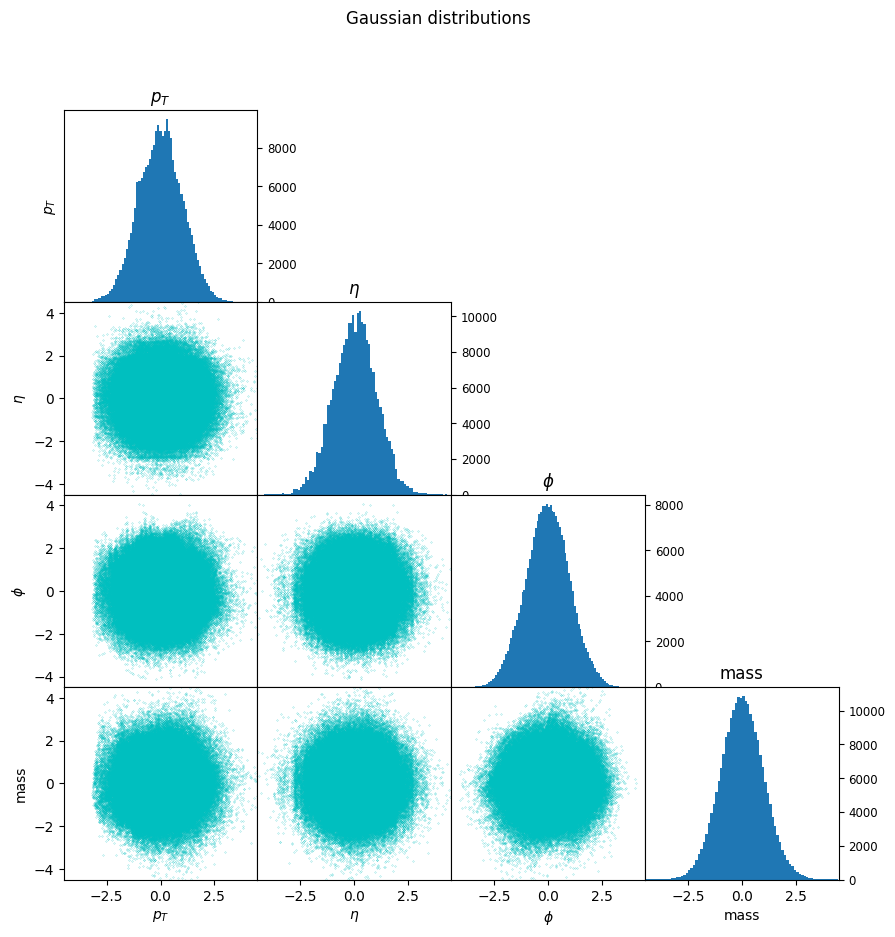

In [ ]:
figgaus, axs = plt.subplots(4,4,figsize=(10,10))
figgaus.suptitle('Gaussian distributions')
figgaus.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus[:,f], bins=n_bins)
        axs[f,f].yaxis.tick_right()
        axs[h,f].set_xlim(-4.5,4.5)
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus[:,f],gaus[:,h],s=0.025,c='c')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus.savefig('figures/Gaussian_plot_model2.png',dpi=190)

As we can read from the scipy documentation: $statistic = s^2+k^2$, where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest. As reported [here](https://www.sciencedirect.com/topics/neuroscience/kurtosis), measures of kurtosis and skew are used to determine if indicators met normality assumptions. Both skew and kurtosis can be analyzed through descriptive statistics. Acceptable values of skewness fall between $\pm$ 3, and kurtosis is appropriate from a range of $\pm$ 10.<br> <br>
The `pvalue` gives us information about the null hypothesis test, i.e. that our data is distributed as a $\mathcal{N}(0,1)$. The null hypothesis $H_0$ is rejected if the p-value is less than or equal to a predefined threshold value $α$, the significance level, which, in our case, is set at $\alpha = 0.05$. Looking at results obtained, we can state that no variable meets the test.

### Ricorda di controllare il valore del pvalue

In [ ]:
statistic, pvalue = stats.normaltest(gaus, axis=0)
print('Statistic = {}, pvalue = {}'.format(statistic,pvalue))

Statistic = [ 84.73650788 383.51811995 129.09313595 438.68033204], pvalue = [3.97833276e-19 5.24926378e-84 9.28499560e-29 5.51793064e-96]


As done for the gaussian distributions, the uniform distributions obtained from the `erf` are now also shown.


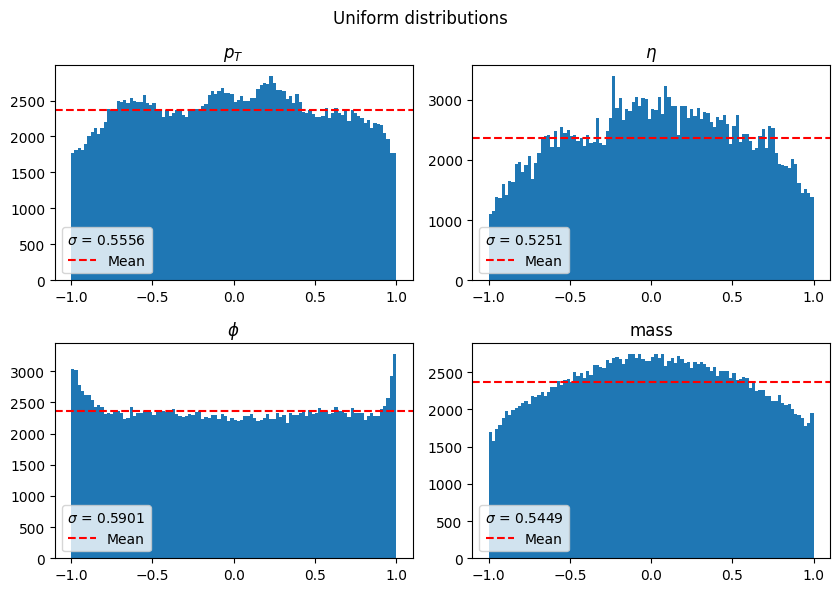

In [ ]:
figunif,axs = plt.subplots(2, 2,figsize=(8.5,6))
figunif.suptitle('Uniform distributions')
n_bins = 100
mean=len(x)/n_bins

axs[0, 0].hist(unif[:,0],bins=n_bins)
axs[0, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{}'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,0])),loc='lower left')

axs[0, 1].hist(unif[:,1],bins=n_bins)
axs[0, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[0, 1].set_title('{}'.format(labels_map[1],unit_measure[1]))
axs[0, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,1])),loc='lower left')

axs[1, 0].hist(unif[:,2],bins=n_bins)
axs[1, 0].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 0].set_title('{}'.format(labels_map[2],unit_measure[2]))
axs[1, 0].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,2])),loc='lower left')

axs[1, 1].hist(unif[:,3],bins=n_bins)
axs[1, 1].axhline(y=mean, color='r', linestyle='--', label='Mean')
axs[1, 1].set_title('{}'.format(labels_map[3],unit_measure[3]))
axs[1, 1].legend(title='$\sigma$ = {:0.4}'.format(np.std(unif[:,3])),loc='lower left')

figunif.tight_layout()
plt.show()
figunif.savefig('figures/Uniform_plot_model2.pdf',dpi=190)

As done for the gaussian distributions obtained from the flow, the same `normaltest` was now repeated also for the gaussian distributions obtained from `erfinv`, those after compression.



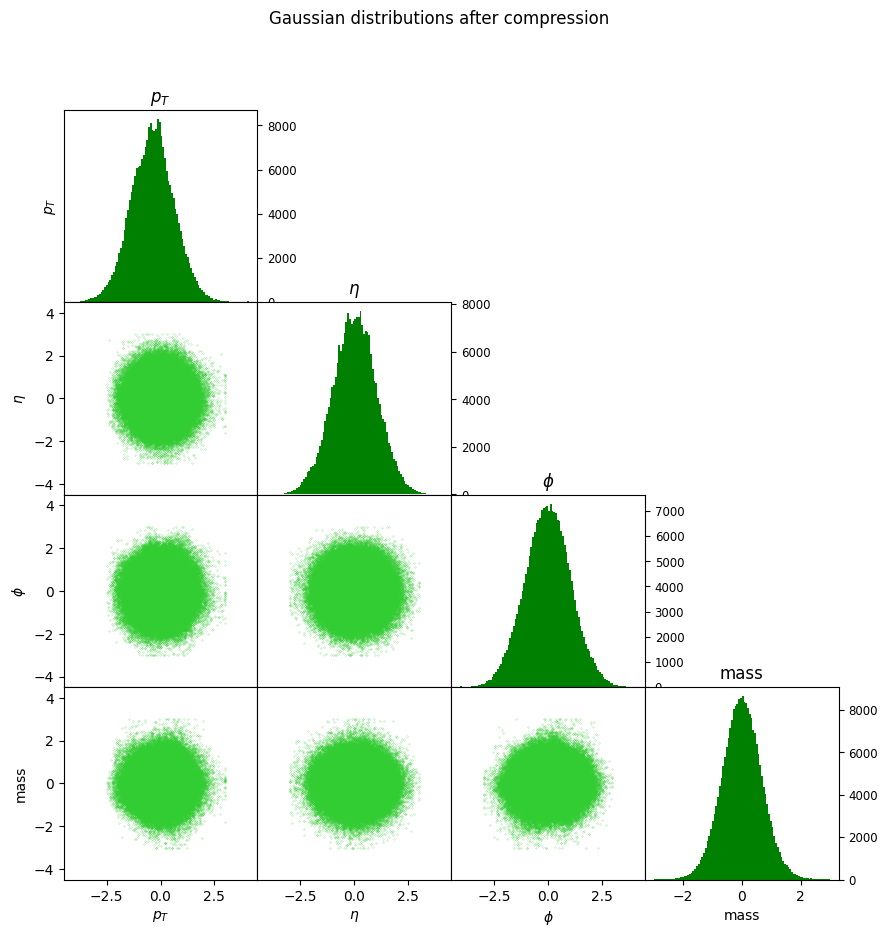

In [ ]:
figgaus_post, axs = plt.subplots(4,4,figsize=(10,10))
figgaus_post.suptitle('Gaussian distributions after compression')
figgaus_post.subplots_adjust(wspace=0, hspace=0)
n_bins=100

for h in range(0,4):
  for f in range(0,4):
    if(f > h): figgaus_post.delaxes(axs[h,f])
    if(f == h):
        axs[f,f].hist(gaus_post[:,f], bins=n_bins, facecolor='g')
        axs[f,f].yaxis.tick_right()
        axs[f,f].yaxis.set_tick_params(labelsize=8.5)
        axs[f,f].set_title(labels_map[f])
        axs[f,f].set_ylim(-10)
    else:
        axs[2,1].set_yticks([]),axs[3,1].set_yticks([]),axs[3,2].set_yticks([])
        axs[h,f].scatter(gaus_post[:,f],gaus_post[:,h],s=0.025,c='limegreen')
        axs[h,f].set_xlim(-4.5,4.5)
        axs[h,f].set_ylim(-4.5,4.5)
    if(f==0):axs[h,f].set_ylabel(labels_map[h])
    if(h==3):axs[h,f].set_xlabel(labels_map[f])

plt.show()
figgaus_post.savefig('figures/Gaussian_post_plot_model2_N20.png',dpi=190)

In [ ]:
statistic_post, pvalue_post = stats.normaltest(gaus_post, axis=0)
print('Statistic post = {}, pvalue post = {}'.format(statistic_post,pvalue_post))

Statistic post = [207.89361574 377.66939068  49.03780678 844.77018347], pvalue post = [7.18579677e-046 9.77538388e-083 2.24685763e-011 3.63484102e-184]


The figure below shows only the distributions of the data, original and decompressed.

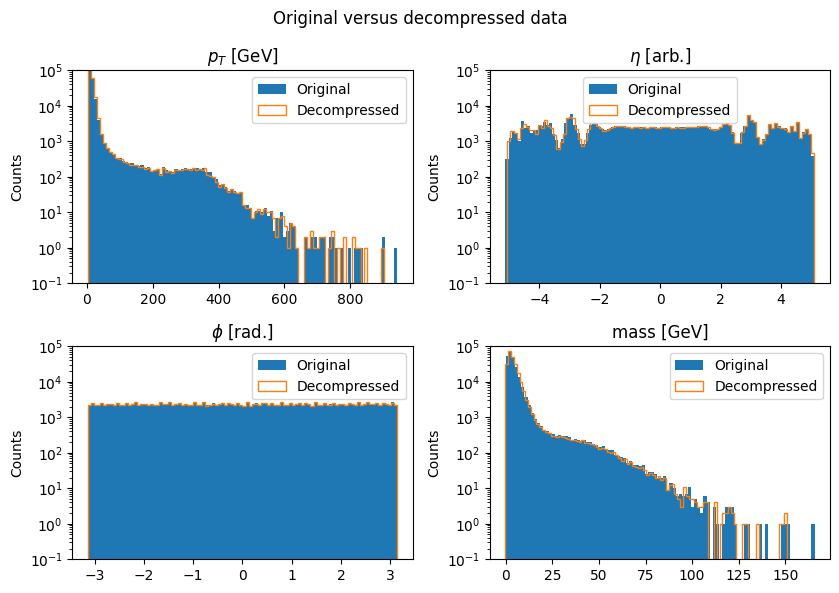

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8.5, 6))
fig.suptitle("Original versus decompressed data")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original',  log=True)
axs[0, 0].hist(x_decompressed[:, 0], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 0].set_title('{} [{}]'.format(labels_map[0],unit_measure[0]))
axs[0, 0].set_ylabel("Counts")
axs[0, 0].set_ylim(1e-1,10e4)
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', log=True)
axs[0, 1].hist(x_decompressed[:, 1], bins=n_bins, label='Decompressed',histtype='step')
axs[0, 1].set_title('{} [{}]'.format(labels_map[1],unit_measure[1]))
axs[0, 1].set_ylabel("Counts")
axs[0, 1].set_ylim(1e-1,10e4)
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', log=True)
axs[1, 0].hist(x_decompressed[:, 2], bins=n_bins, label='Decompressed',histtype='step')
axs[1, 0].set_title('{} [{}]'.format(labels_map[2],unit_measure[2]))
axs[1, 0].set_ylabel("Counts")
axs[1, 0].legend()
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', log=True)
axs[1, 1].hist(x_decompressed[:, 3], bins=n_bins, label='Decompressed', histtype='step')
axs[1, 1].set_title('{} [{}]'.format(labels_map[3],unit_measure[3]))
axs[1, 1].set_ylabel("Counts")
axs[1, 1].legend()
axs[1,1].sharey(axs[0,0])

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison_model2.pdf', dpi=190)


We now represent the original and decompressed data, in particular by plotting the ratio, defined as *ratio = original/decompressed*, and distribution of the *difference = decompressed - original*. <br>
The difference, together with the response distribution, is a metric used by [Baler](https://arxiv.org/abs/2305.02283) to evaluate compression.

<ipython-input-10-b8ac4d93366b>:25: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-10-b8ac4d93366b>:25: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


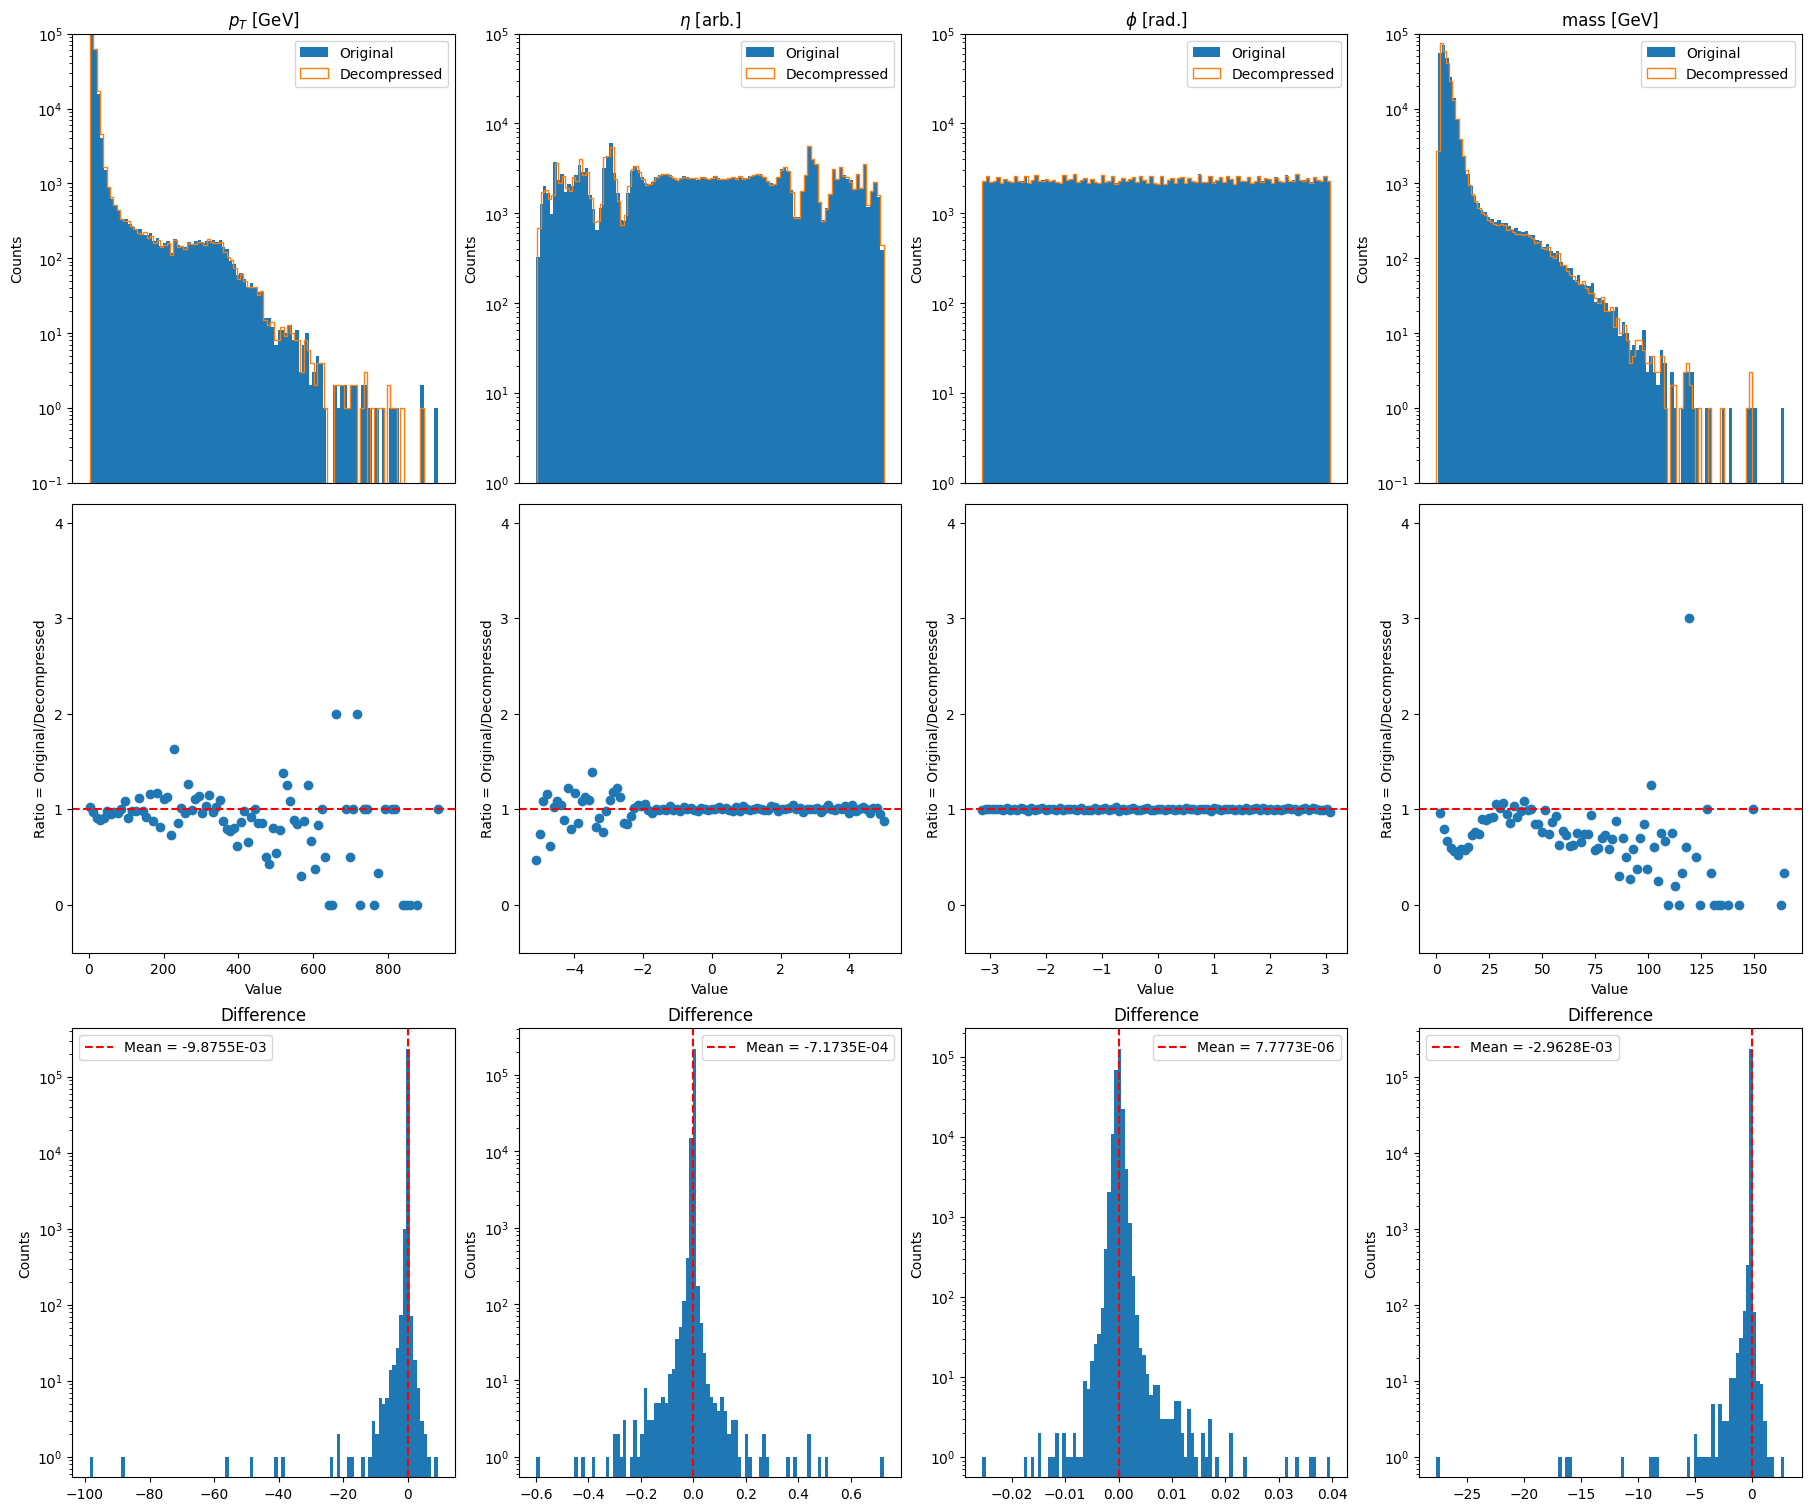

In [ ]:
difference = x_decompressed-x

fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')

n_bins = 100

for i in range(4):
    y = []
    y.append(x[:, i])
    y.append(x_decompressed[:, i])

    ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
    ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
    axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
    axs[0, i].set_ylabel("Counts")
    axs[0, i].legend()
    axs[0, i].set_ylim(1e-1,10e4)
    axs[0, i].get_xaxis().set_ticks([])
    if i in [0,3]:
      axs[0, i].set_ylim(1e-1,10e4)
    if i in [1,2]:
      axs[0, i].set_ylim(1,10e4)


    axs[1, i].scatter(bins[:-1],ns/ns1)
    axs[1, i].axhline(y=1, color='r', linestyle='--')
    axs[1, i].set_xlabel("Value")
    axs[1, i].set_ylabel("Ratio = Original/Decompressed")
    axs[1, i].set_ylim(-0.5,4.2)
    axs[1, i].ticklabel_format(style='scientific')


    axs[2, i].hist(difference[:, i],bins = n_bins,log=True)
    axs[2, i].set_title("Difference")
    axs[2, i].set_ylabel("Counts")
    axs[2, i].axvline(x=np.mean(difference[:, i]), color='r', linestyle='--',label='Mean = {:.4E}'.format(np.mean(difference[:, i])))
    axs[2, i].legend()

plt.show()
fig_diff.savefig('figures/difference_model2_N20.pdf', dpi=250)

We now deal with the response, defined as
\begin{equation*}
response = \frac{decompressed - original}{original}
\end{equation*}
<br><br>
We also need to deal with the infinities and NaN's that can result from dividing. These are counted and replaced by zero.

In [ ]:
response = np.divide(difference,x)

count = np.zeros(shape=(4))

for t in range(0,num_features):
  for y in range(0,len(response)):
    if np.isnan(response[y][t]) == True:
      count[t] +=1
    if np.isinf(response[y][t]) == True:
      count[t] +=1
      response[y][t] = 0
    if np.abs(response[y][t]) > 6e5:
      count[t] +=1
      response[y][t] = 0
print('Nans & Infs =', count)

mean_response = np.zeros(shape=(4))
for d in range(0,num_features):
  mean_response[d] = np.mean(response[:,d])

<ipython-input-11-0d6b63a6bfb4>:1: RuntimeWarning: divide by zero encountered in divide
  response = np.divide(difference,x)


Nans & Infs = [ 0.  0.  0. 25.]


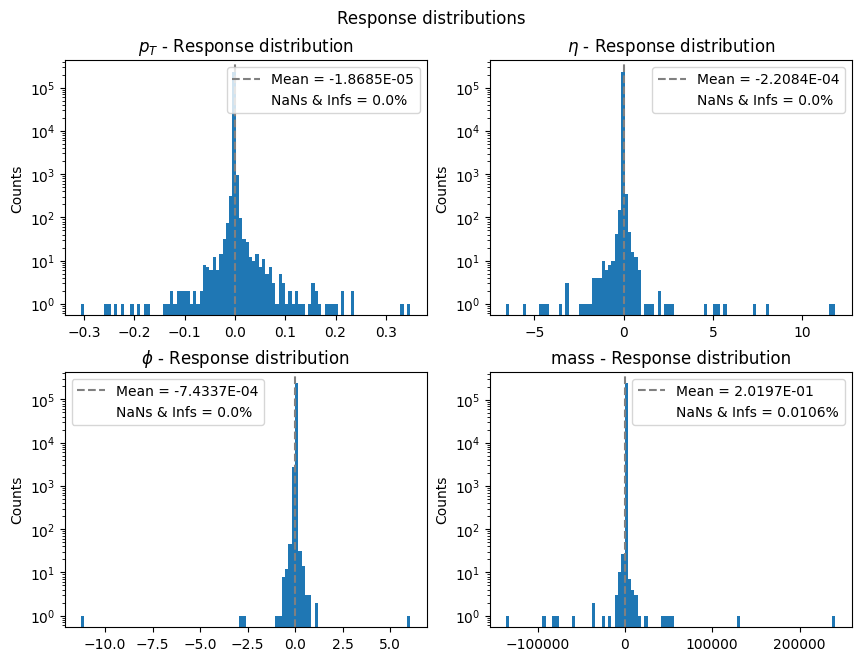

In [ ]:
fig_response, axs = plt.subplots(2, 2, figsize=(8.5, 6.5), layout='constrained')
fig_response.suptitle("Response distributions")

axs[0,0].set_title('{} - Response distribution'.format(labels_map[0]))
axs[0,0].hist(response[:,0], bins=n_bins, log=True)
axs[0,0].set_ylabel("Counts")
axs[0,0].axvline(x=mean_response[0], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[0]))
axs[0,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[0]*100/len(response)))
axs[0,0].legend()

axs[0,1].set_title('{} - Response distribution'.format(labels_map[1]))
axs[0,1].hist(response[:,1], bins=n_bins, log=True)
axs[0,1].set_ylabel("Counts")
axs[0,1].axvline(x=mean_response[1], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[1]))
axs[0,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[1]*100/len(response)))
axs[0,1].legend()

axs[1,0].set_title('{} - Response distribution'.format(labels_map[2]))
axs[1,0].hist(response[:,2], bins=n_bins, log=True)
axs[1,0].set_ylabel("Counts")
axs[1,0].axvline(x=mean_response[2], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[2]))
axs[1,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[2]*100/len(response)))
axs[1,0].legend()

axs[1,1].set_title('{} - Response distribution'.format(labels_map[3]))
axs[1,1].hist(response[:,3], bins=n_bins, log=True)
axs[1,1].set_ylabel("Counts")
axs[1,1].axvline(x=mean_response[3], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response[3]))
axs[1,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count[3]*100/len(response)))
axs[1,1].legend()

plt.show()
fig_response.savefig('figures/response_model2_N13.pdf', dpi=190)

To get the compression ratio, defined as
\begin{equation*}
R = \frac{size(input~file)}{size(compressed~file)},
\end{equation*}
new `.txt` files are created to contain only the data actually used, so we take into account the reductions made to the number of entries and the number of features. To be consistent with [Baler](https://arxiv.org/abs/2305.02283), the `.npz` format is also used to create new files.

The compression ratio is shown below.

In [ ]:
###.txt files

with open('input.txt', 'w') as input:
    for i in range(len(x)):
        input.write(' '.join(str(x[i, j]) for j in range(x.shape[1])) + "\n")

with open('output.txt', 'w') as output:
    for i in range(len(x)):
        output.write(' '.join(str(x_decompressed[i, j]) for j in range(x_decompressed.shape[1])) + "\n")

with open('compressed.txt', 'w') as compressed:
    for i in range(len(x)):
        compressed.write(' '.join(str(x_compressed[i, j]) for j in range(x_compressed.shape[1])) + "\n")

size_input = stat('input.txt').st_size
print('Size of input file =',size_input/(1024*1024),'MB')

size_output = stat('output.txt').st_size
print('Size of output file =',size_output/(1024*1024),'MB')

size_compressed = stat('compressed.txt').st_size
print('Size of compressed file =',size_compressed/(1024*1024),'MB')

print('Compression ratio (.txt) =',size_input/size_compressed,'\n')

###.npz files
np.savez_compressed('input.npz', data=x)
np.savez_compressed('output.npz', data=x_decompressed)
np.savez_compressed('compressed.npz', data=x_compressed)

size_input_npz = stat('input.npz').st_size
print('Size of input file =',size_input_npz/(1024*1024),'MB')

size_output_npz = stat('output.npz').st_size
print('Size of output file =',size_output_npz/(1024*1024),'MB')

size_compressed_npz = stat('compressed.npz').st_size
print('Size of compressed file =',size_compressed_npz/(1024*1024),'MB')

print('Compression ratio (.npz) =',size_input_npz/size_compressed_npz)

Size of input file = 12.898502349853516 MB
Size of output file = 16.96665668487549 MB
Size of compressed file = 4.822744369506836 MB
Compression ratio (.txt) = 2.674515039902994 

Size of input file = 5.3632049560546875 MB
Size of output file = 6.964774131774902 MB
Size of compressed file = 2.338810920715332 MB
Compression ratio (.npz) = 2.2931331936890116


We now study the compression ratio, the mean of the module of the differences and the relative error as a function of $N$.


The definition of R and of the difference is given above, instead we have:
$$
Relative~error =\overline{\sqrt{\overline{\Big(\frac{original-decompressed}{std(original)}\Big)^2}}}
$$
where $std(x) = \sqrt{\frac{1}{N}\sum^{N}_{i=1}(x_i-\mu)^2}$ is the standard deviation of $x$ and $\mu$ is its mean.
Furthermore, the average under the square root is done column by column using `axis=0`. As expected, a decreasing behaviour is obtained for all functions.<br> The value of the mean of the modulus of the residuals and the relative error for the two chosen values of $N$ is also printed out.

In [ ]:
RR_txt = []
RR_npz = []
residui = []
relative_error = []

for k in range(1,32):
    x_compressor_k = Compressor(flow=flow, N=k, limit=3)
    x_compressed_k, gaus_k, unif_ = x_compressor_k.compress(xt)
    x_decompressed_k, gaus_post_k = x_compressor_k.decompress(x_compressed_k)
    x_decompressed_k = x_preprocessor.backward(x_decompressed_k)

    with open('compressed_k.txt', 'w') as compressed:
        for i in range(len(x)):
            compressed.write(' '.join(str(x_compressed_k[i, j]) for j in range(x_compressed_k.shape[1])) + "\n")

    size_compressed_k = stat('compressed_k.txt').st_size
    r_k = size_input/size_compressed_k
    RR_txt.append(r_k)

    np.savez_compressed('compressed_k.npz', data=x_compressed_k)

    size_compressed_k_npz = stat('compressed_k.npz').st_size
    r_k_npz = size_input_npz/size_compressed_k_npz
    RR_npz.append(r_k_npz)

    residui_k = np.mean(np.abs(x-x_decompressed_k))
    if k == 13 or k == 20:
      print('Mean of module of residual for N={}: {}'.format(k,residui_k))
    residui.append(residui_k)

    err_k =np.mean(np.sqrt(np.mean(((x - x_decompressed_k)/(x.std()))**2, axis=0)))
    if k == 13 or k == 20:
      print('Relative error for N={}: {}'.format(k,err_k))
    relative_error.append(err_k)

Mean of module of residual for N=13: 0.0024673348549931226
Relative error for N=13: 0.0007432784333694768
Mean of module of residual for N=20: 1.9782573090799058e-05
Relative error for N=20: 8.076871850485341e-06


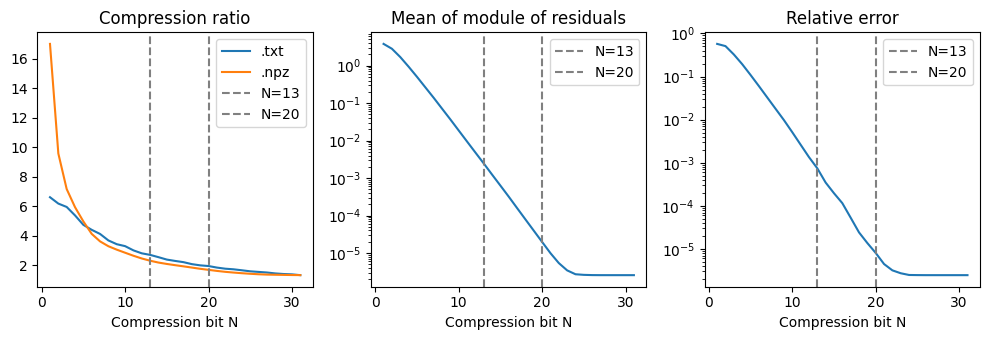

In [ ]:
fig, ax1 = plt.subplots(1,3,figsize=(10,3.5))

ax1[0].plot(range(1,k+1),RR_txt,label='.txt')
ax1[0].plot(range(1,k+1),RR_npz,label='.npz')
ax1[0].set_xlabel('Compression bit N')
ax1[0].set_title('Compression ratio')
ax1[0].tick_params(axis='y', which='minor', bottom=False)
ax1[0].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[0].axvline(x=20, color='grey', linestyle='--',label='N=20')
ax1[0].legend()

ax1[1].plot(range(1,k+1),residui)
ax1[1].set_xlabel('Compression bit N')
ax1[1].set_title('Mean of module of residuals')
ax1[1].set_yscale('log')
ax1[1].tick_params(axis='y', which='minor', bottom=False)
ax1[1].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[1].axvline(x=20, color='grey', linestyle='--',label='N=20')
ax1[1].legend()

ax1[2].plot(range(1,k+1),relative_error)
ax1[2].set_xlabel('Compression bit N')
ax1[2].set_title('Relative error')
ax1[2].set_yscale('log')
ax1[2].tick_params(axis='y', which='minor', bottom=False)
ax1[2].axvline(x=13, color='grey', linestyle='--',label='N=13')
ax1[2].axvline(x=20, color='grey', linestyle='--',label='N=20')
ax1[2].legend()

fig.tight_layout()
plt.show()
fig.savefig('figures/Compression_ratio_model1.pdf',dpi=190)

Now the testing part is performed, so compressing new data with the previously trained flow. Five subsets of 200000 entries
each were extracted from the `xtest_all` dataset. The procedure is similar to the one carried out previously: the data is preprocessed, the flow is used to compress this data and then it goes back, using `decompress` and `backward`. We always set `N=13`. Plots for the original and decompressed distributions, ratios, differences and responses for each data set are reported.

<ipython-input-9-271f74263062>:66: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-9-271f74263062>:66: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


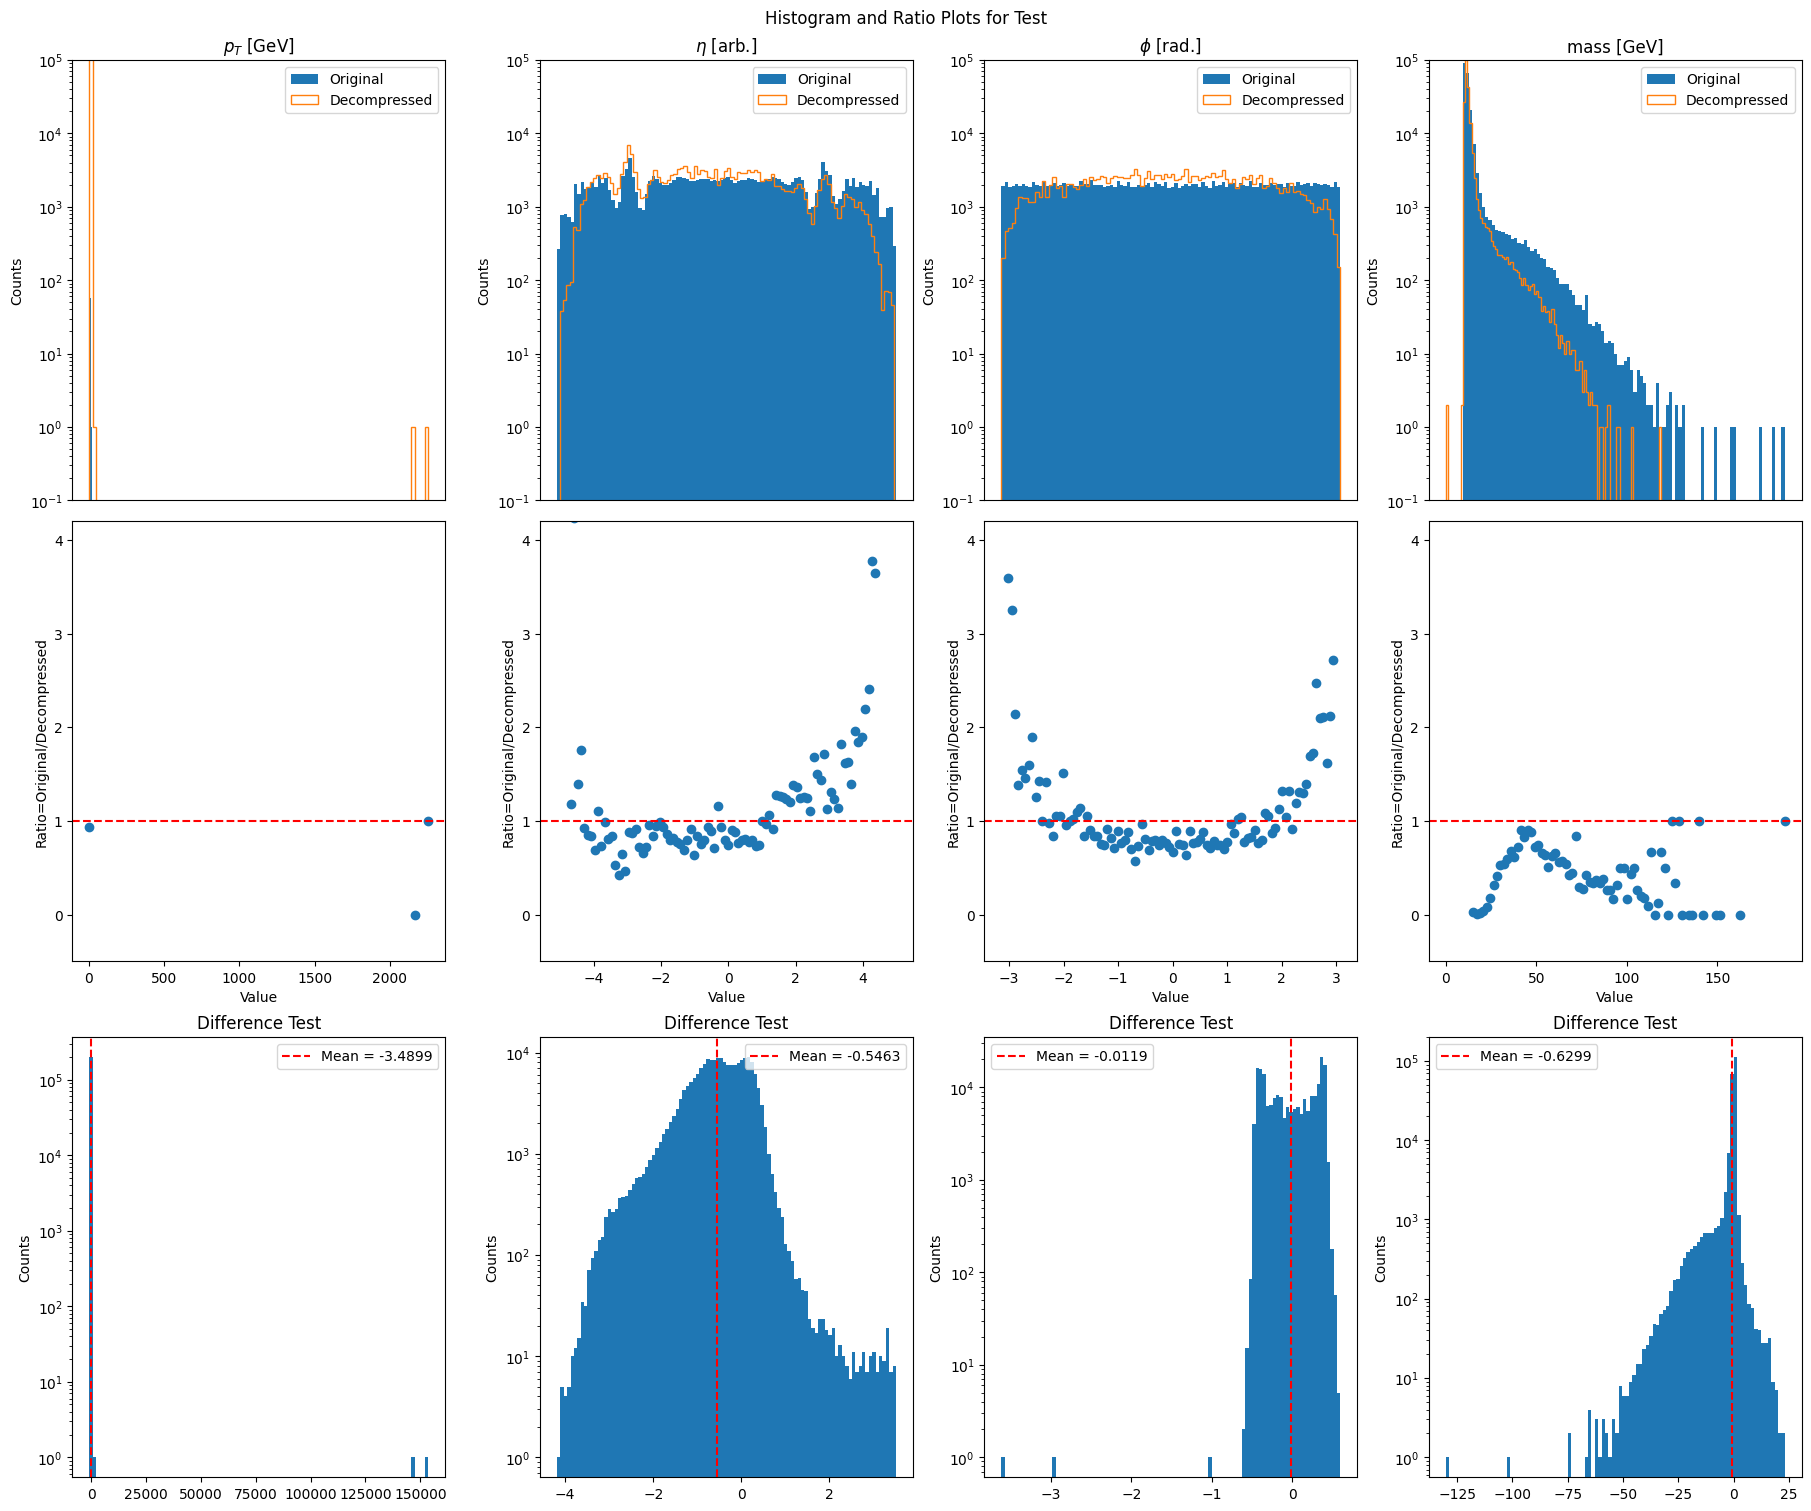

<ipython-input-9-271f74263062>:83: RuntimeWarning: divide by zero encountered in divide
  response_test = np.divide(difference_test,xtest)


Nans & Infs = [ 0.  0.  0. 13.]


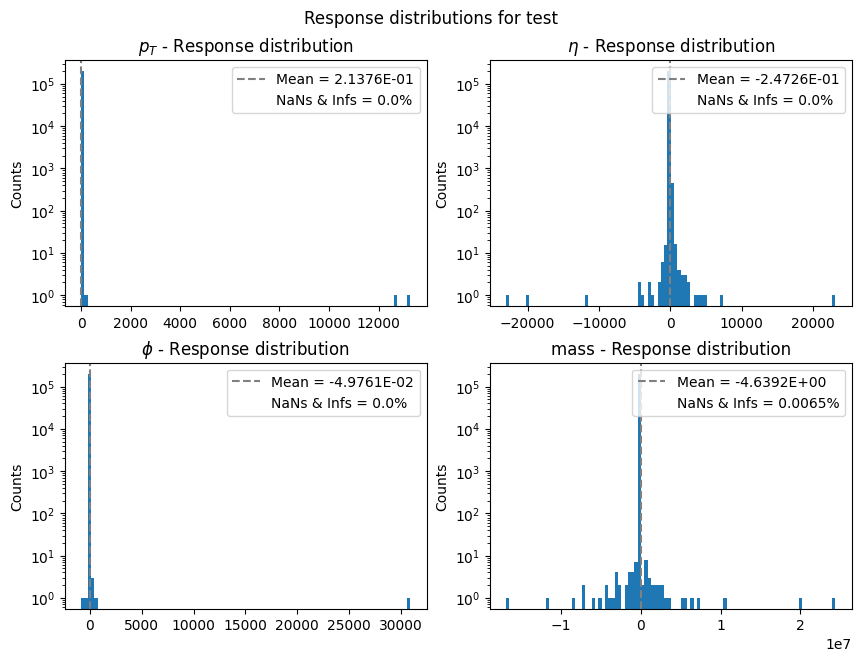

<ipython-input-9-271f74263062>:66: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-9-271f74263062>:66: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


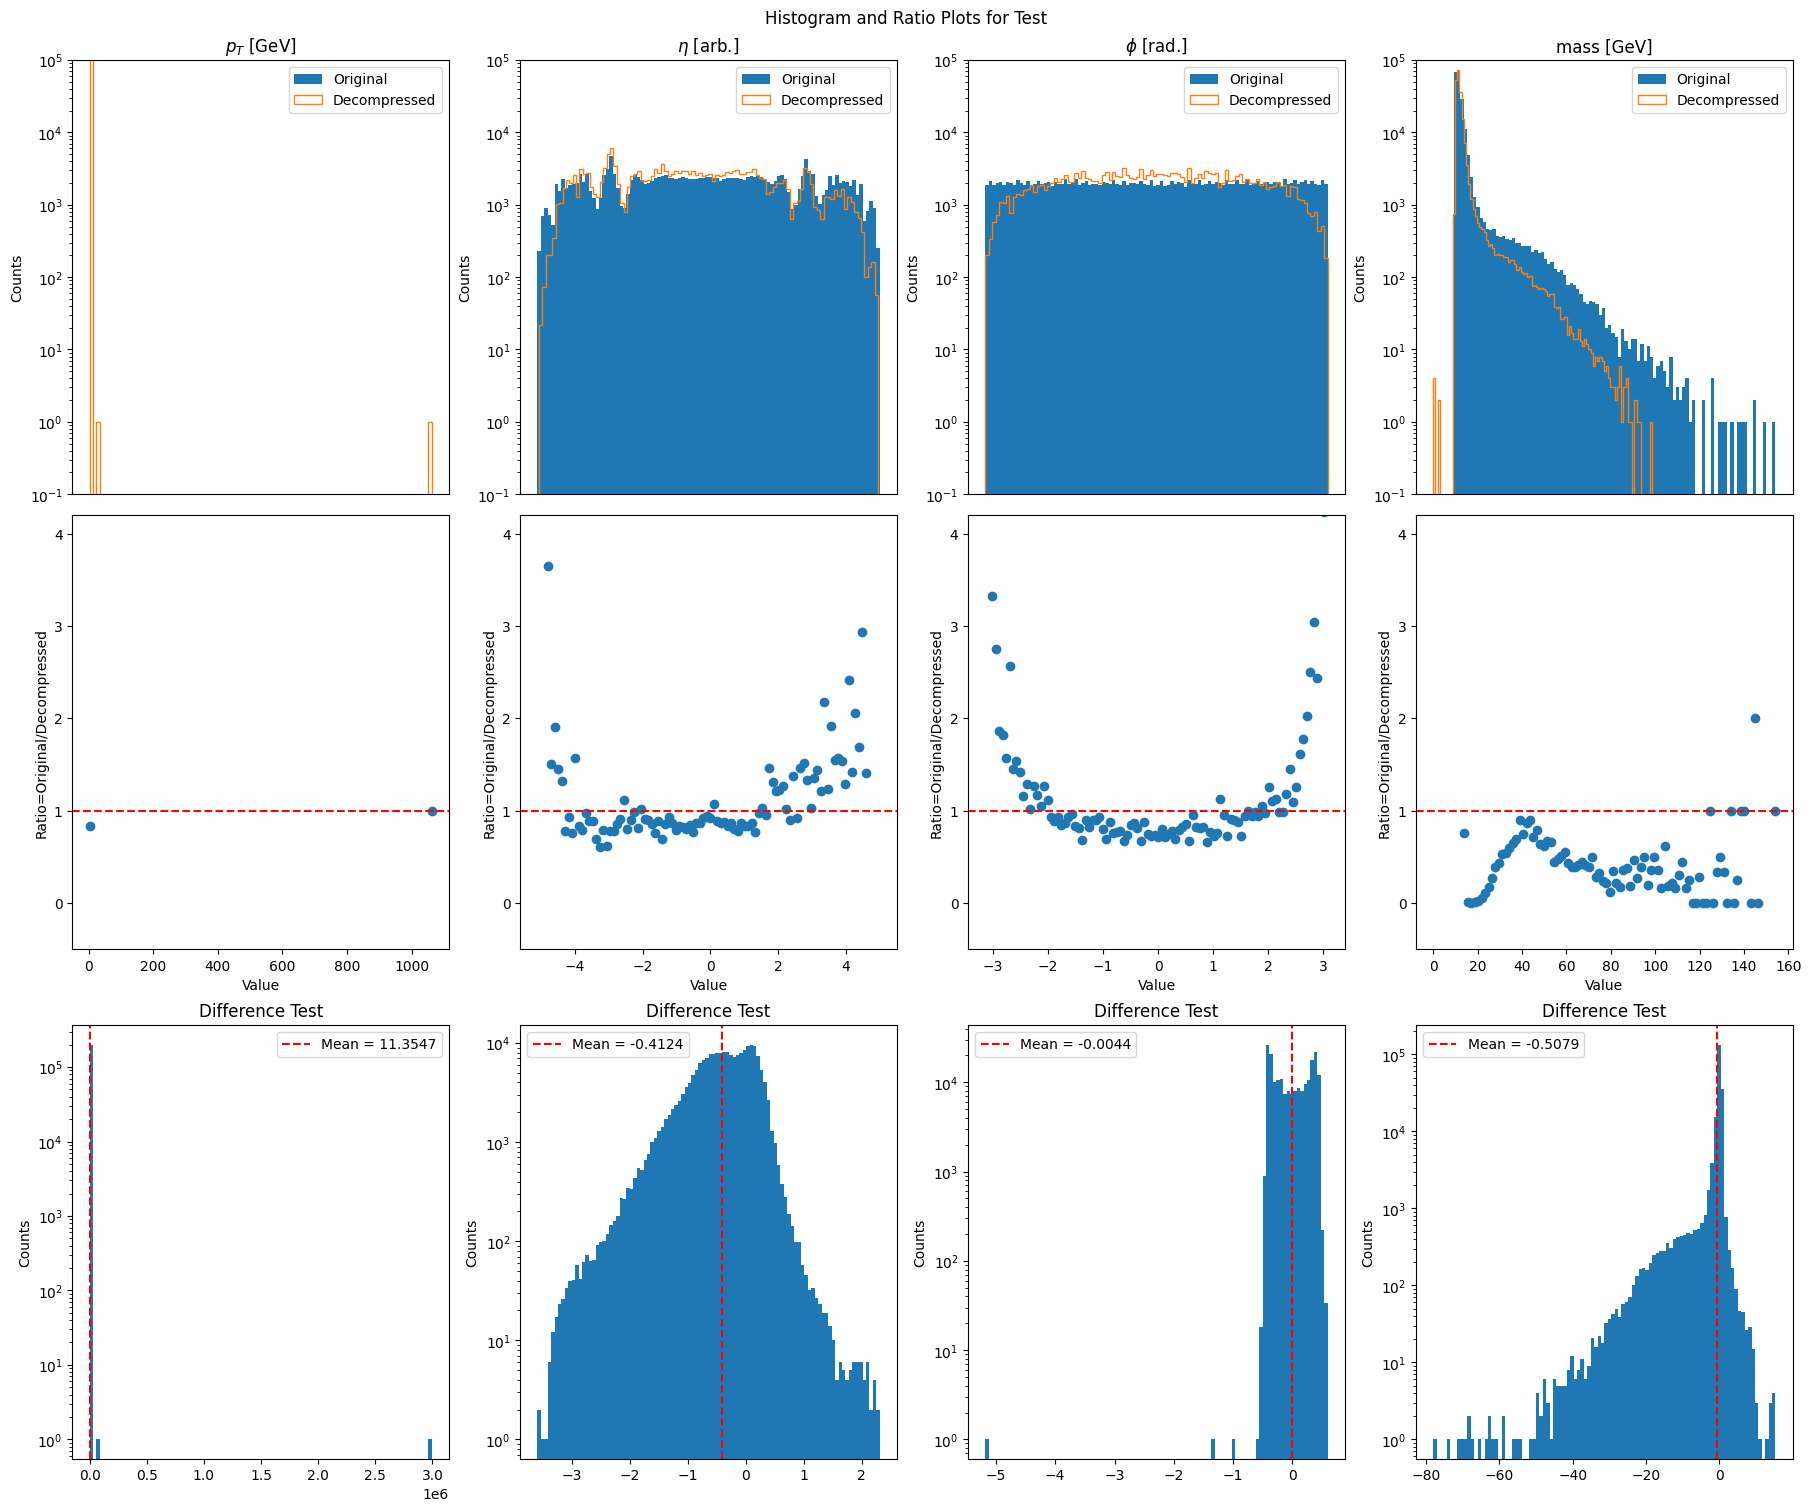

<ipython-input-9-271f74263062>:83: RuntimeWarning: divide by zero encountered in divide
  response_test = np.divide(difference_test,xtest)


Nans & Infs = [ 0.  0.  0. 11.]


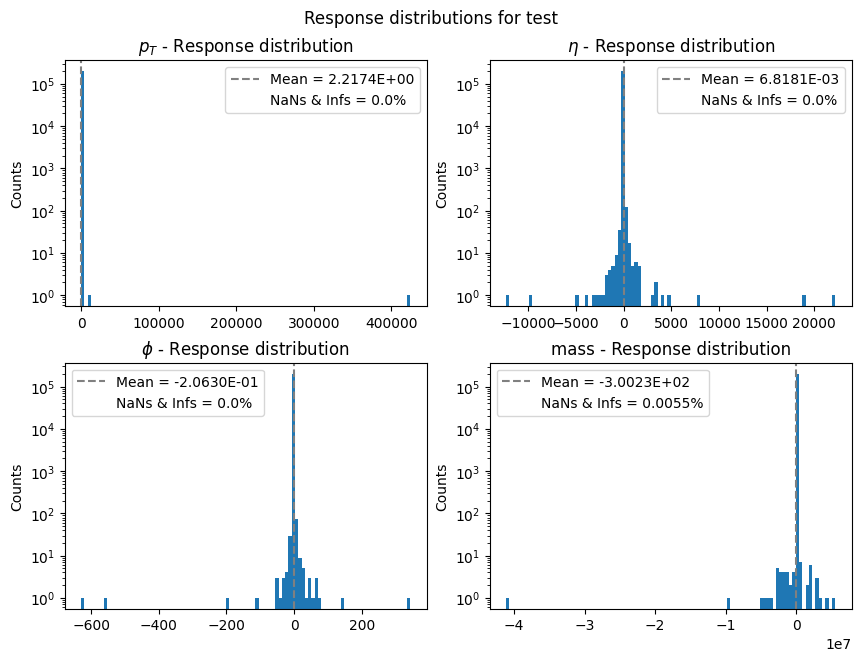

<ipython-input-9-271f74263062>:66: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-9-271f74263062>:66: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


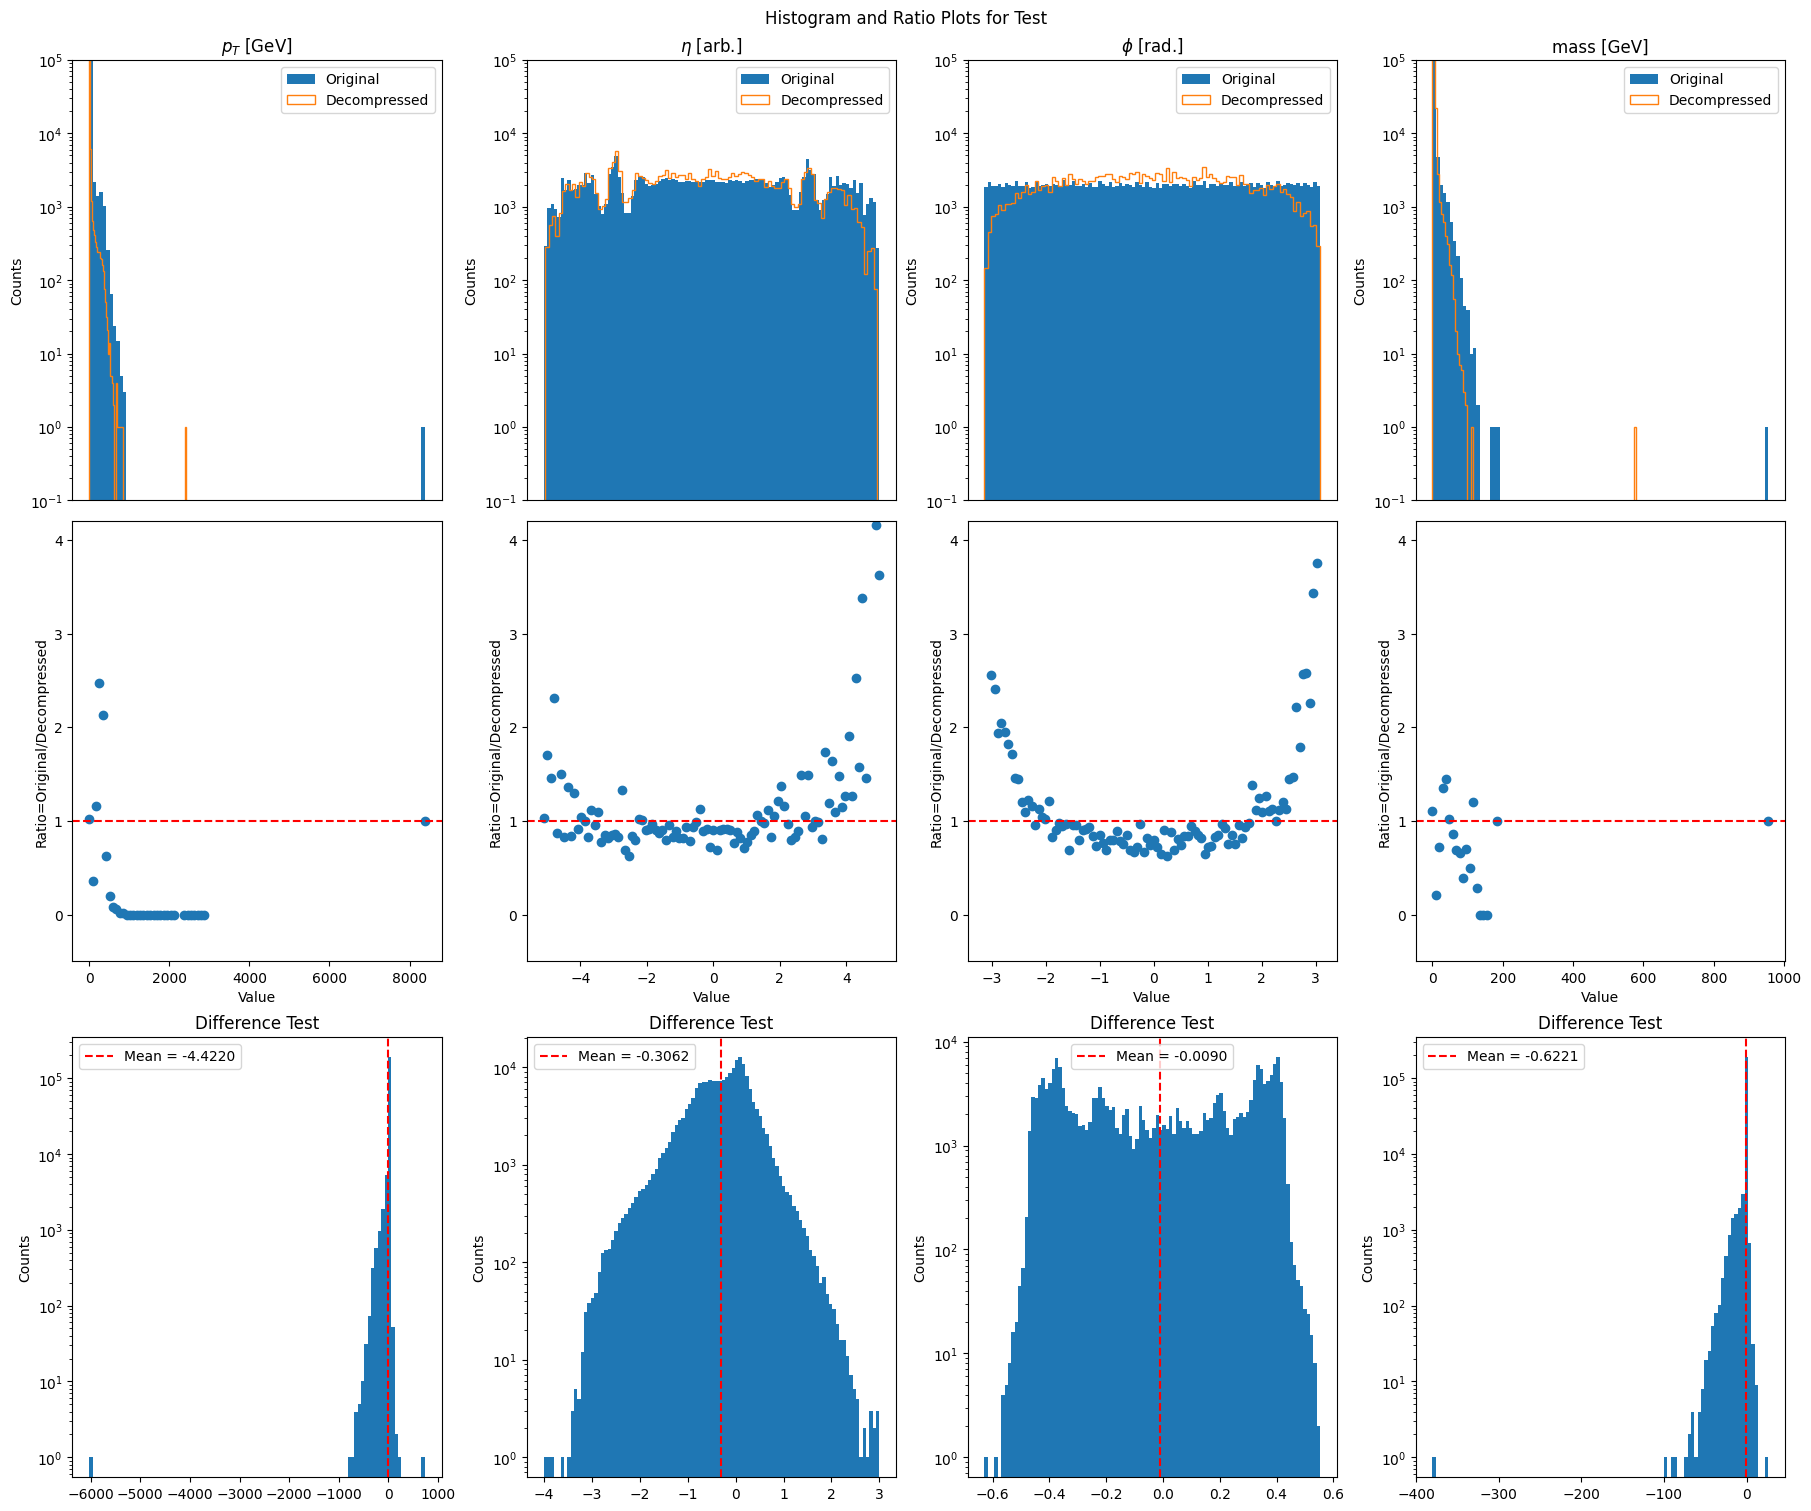

<ipython-input-9-271f74263062>:83: RuntimeWarning: divide by zero encountered in divide
  response_test = np.divide(difference_test,xtest)


Nans & Infs = [ 0.  0.  0. 14.]


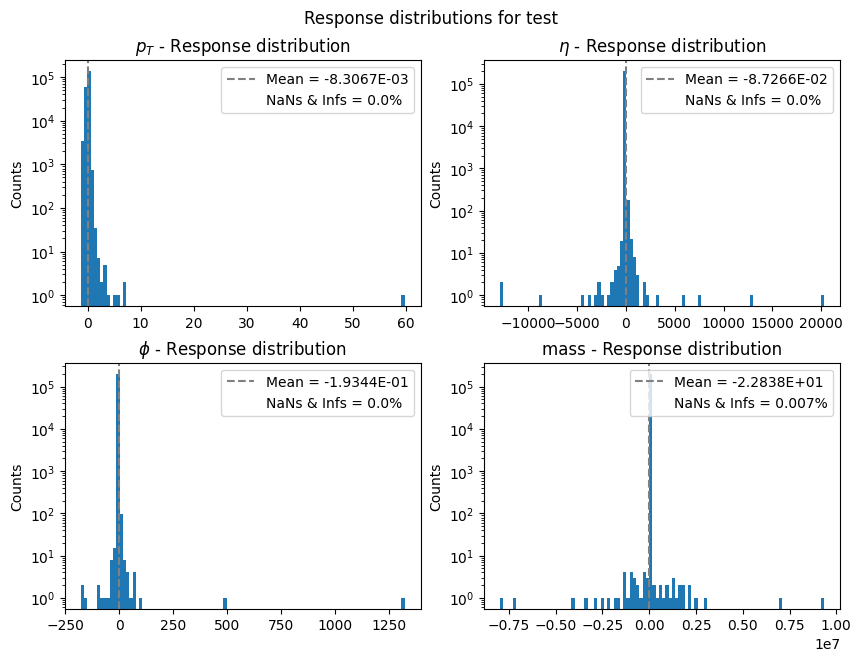

<ipython-input-9-271f74263062>:66: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-9-271f74263062>:66: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


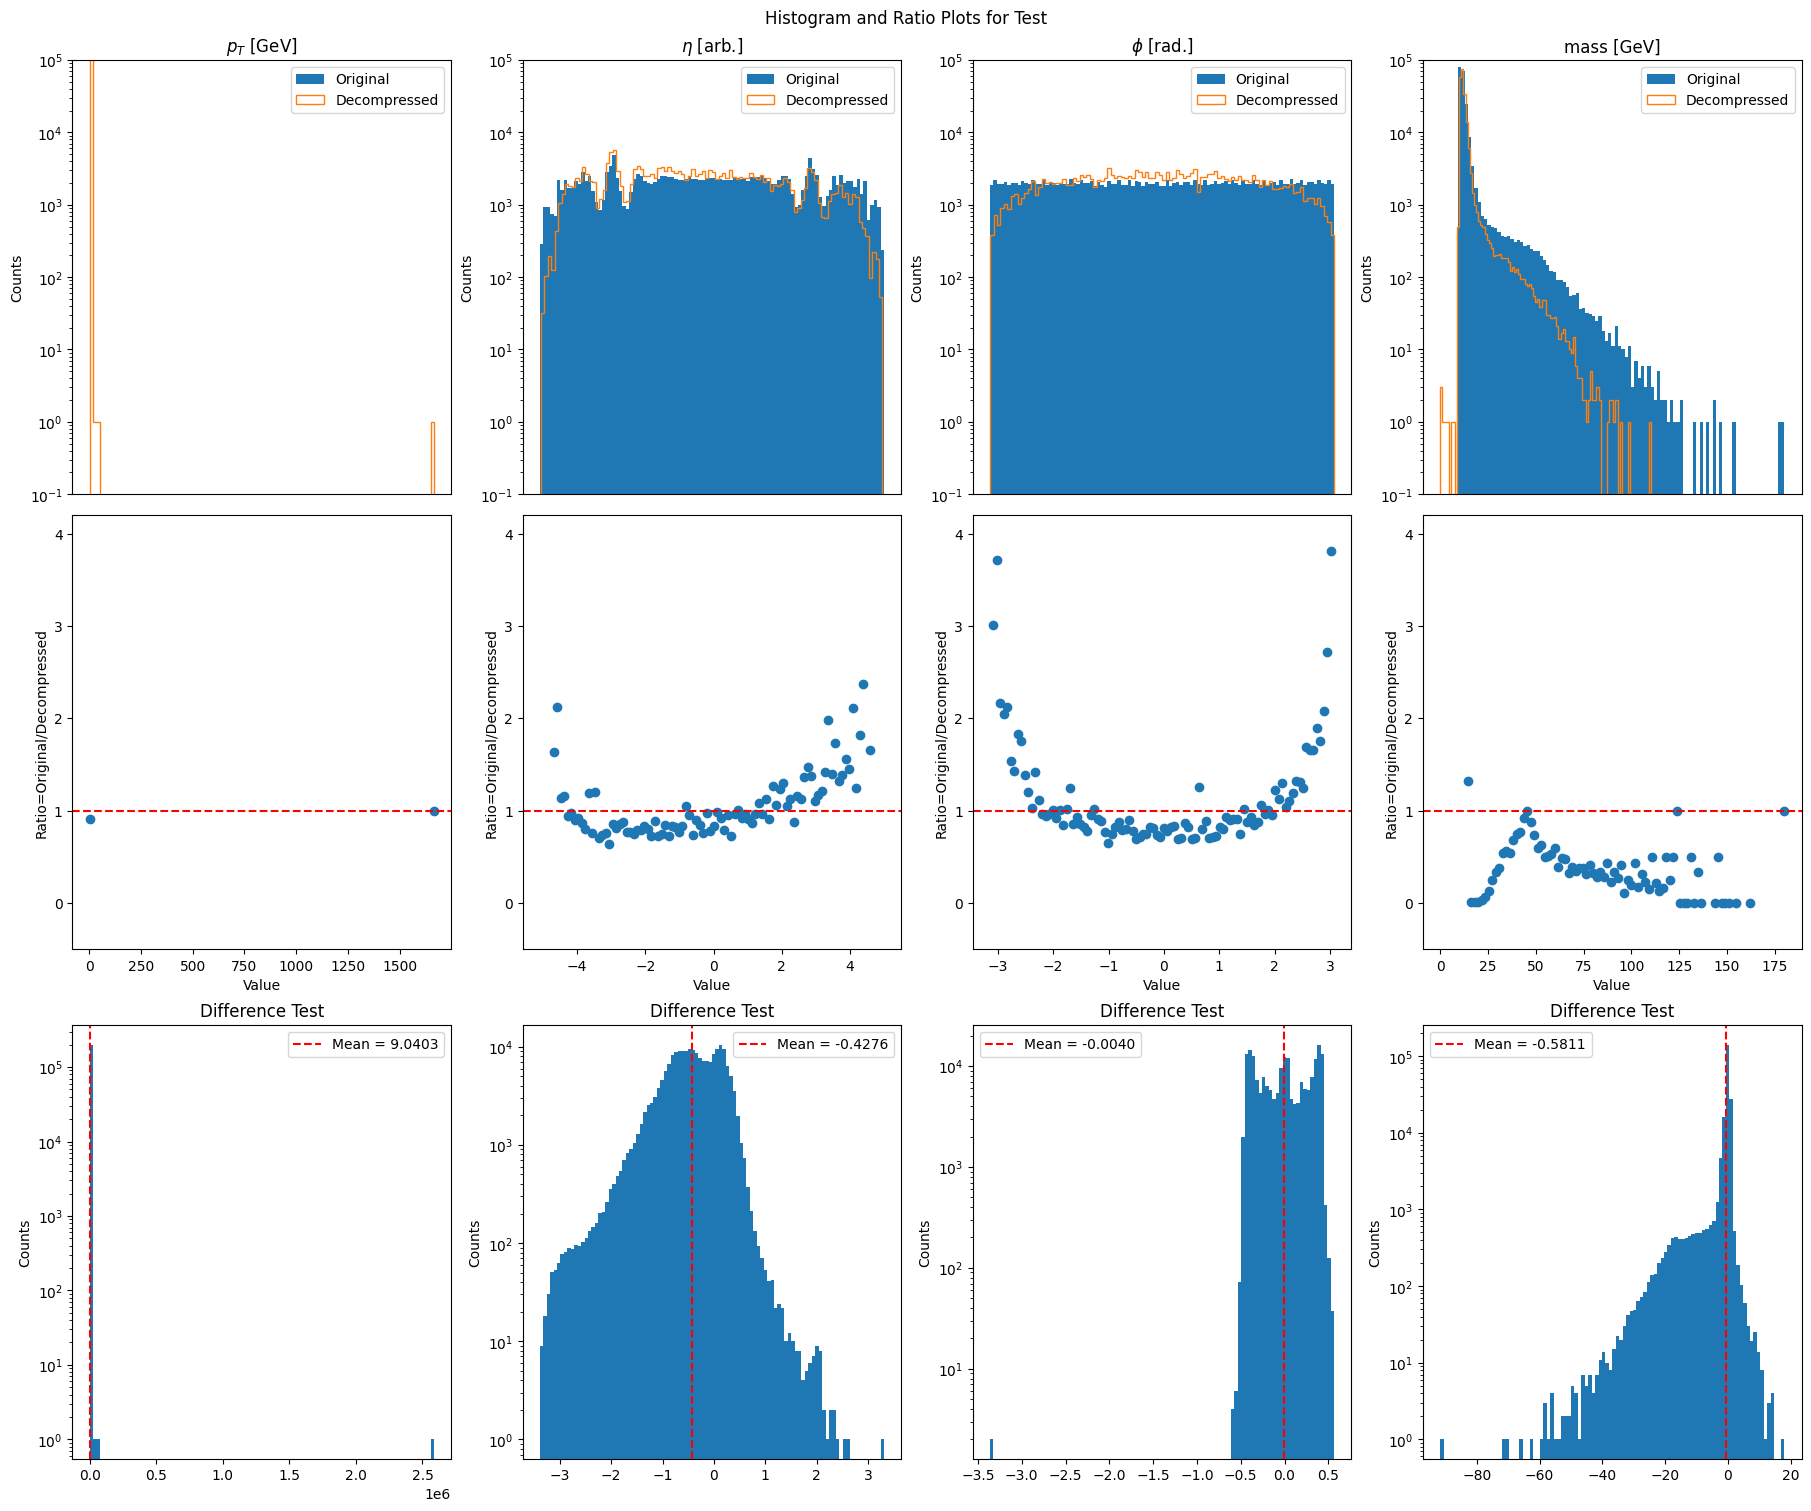

<ipython-input-9-271f74263062>:83: RuntimeWarning: divide by zero encountered in divide
  response_test = np.divide(difference_test,xtest)


Nans & Infs = [0. 0. 0. 6.]


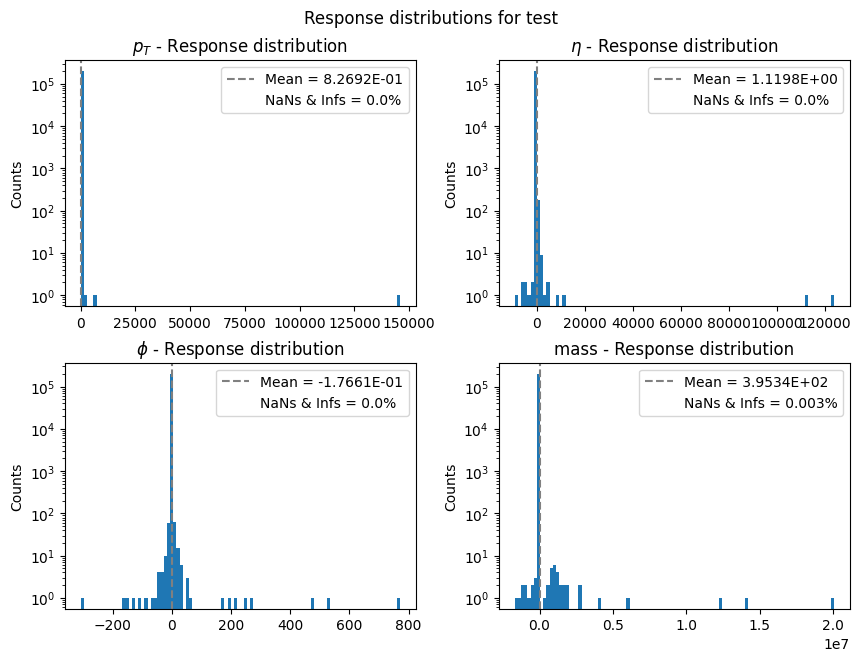

<ipython-input-9-271f74263062>:66: RuntimeWarning: divide by zero encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)
<ipython-input-9-271f74263062>:66: RuntimeWarning: invalid value encountered in divide
  axs[1, i].scatter(bins[:-1],ns/ns1)


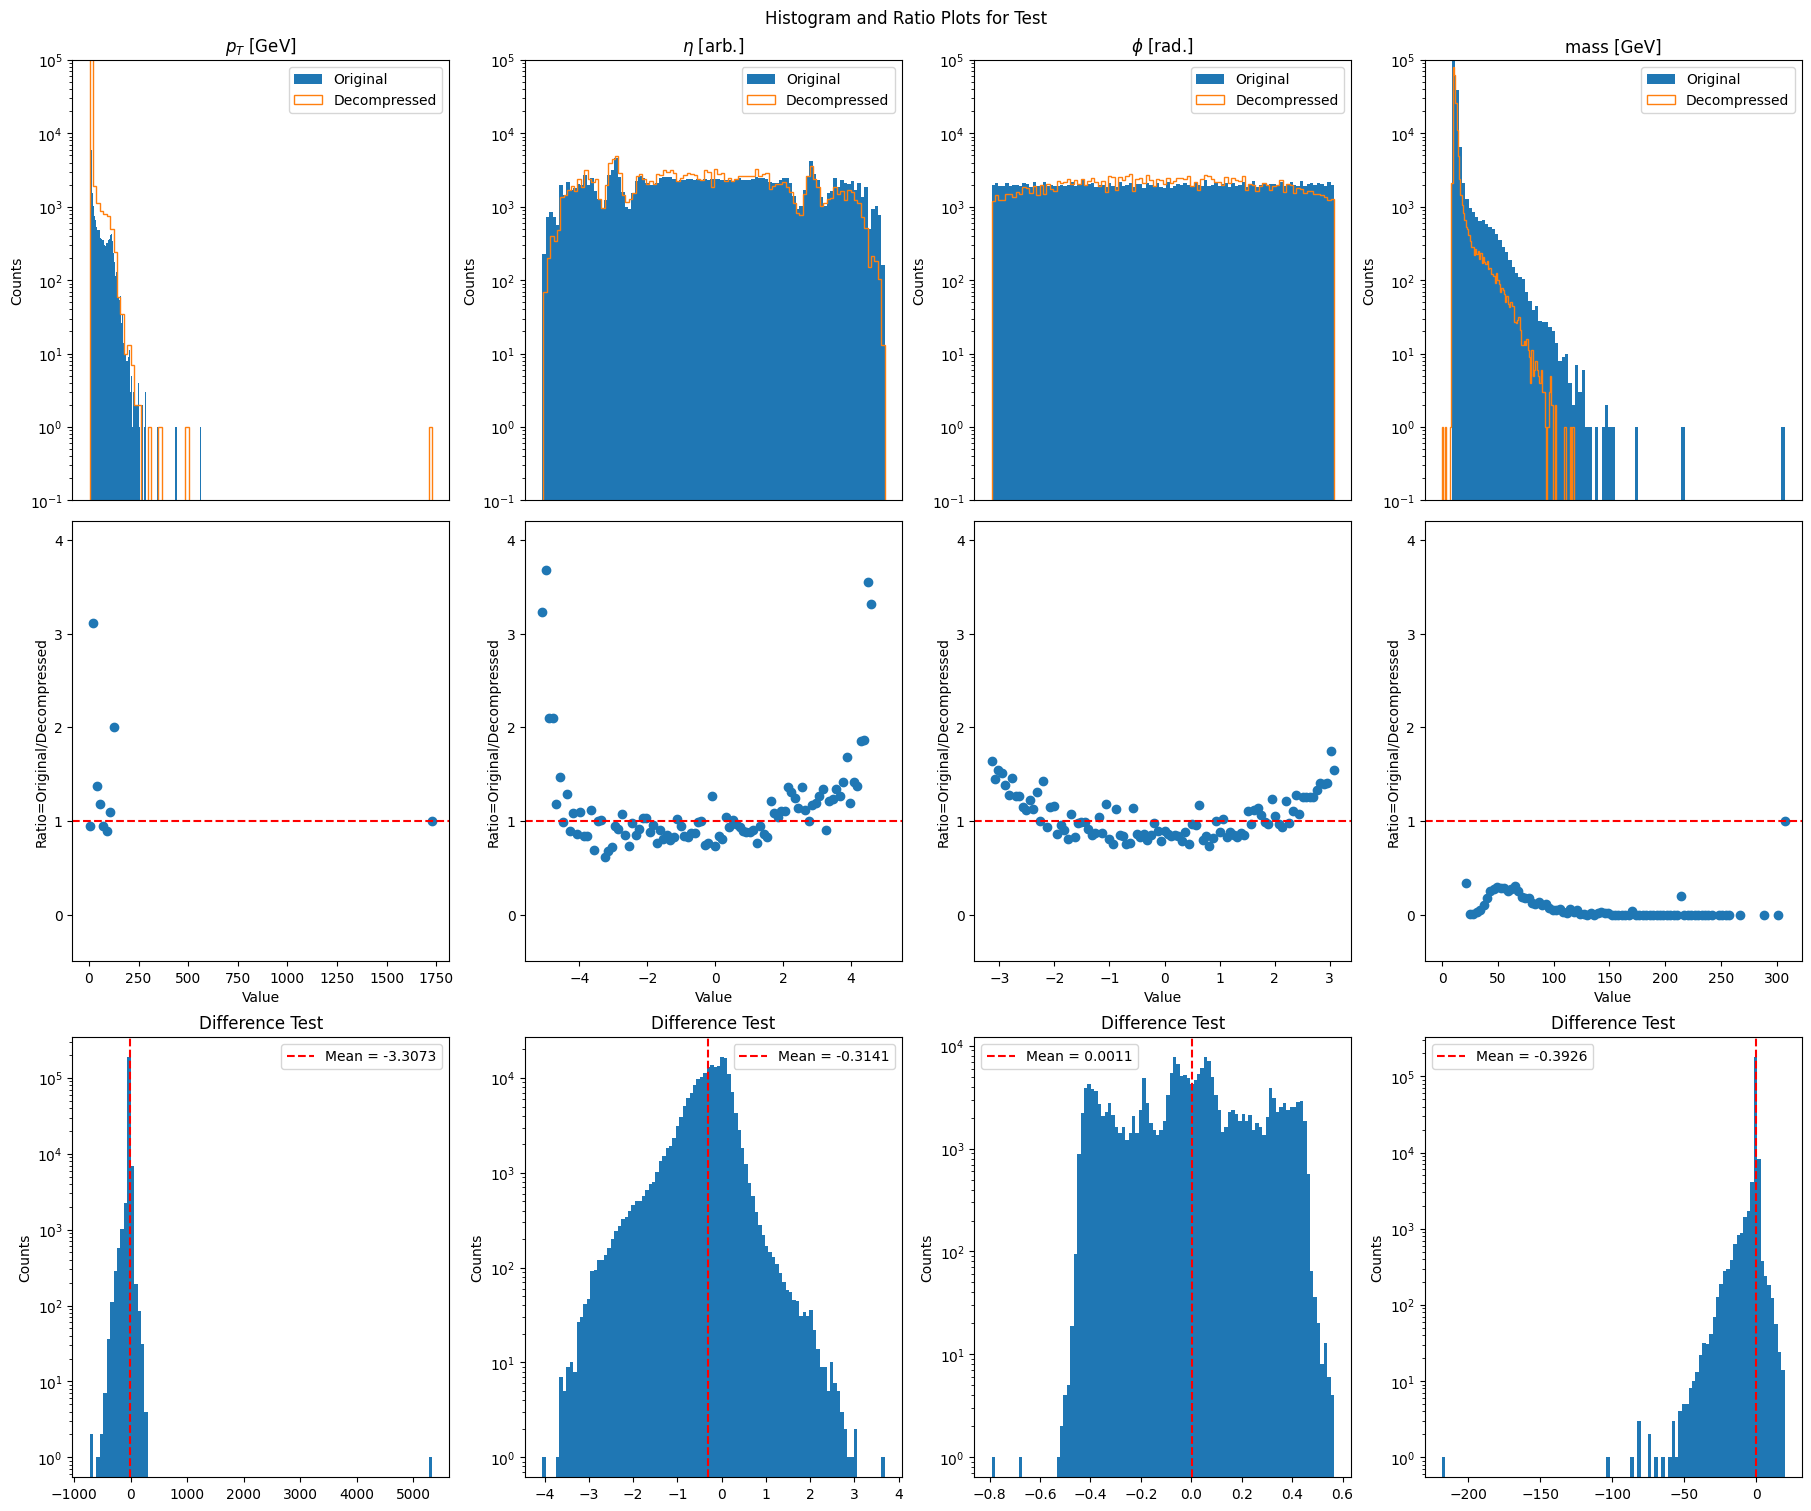

<ipython-input-9-271f74263062>:83: RuntimeWarning: divide by zero encountered in divide
  response_test = np.divide(difference_test,xtest)


Nans & Infs = [0. 0. 0. 9.]


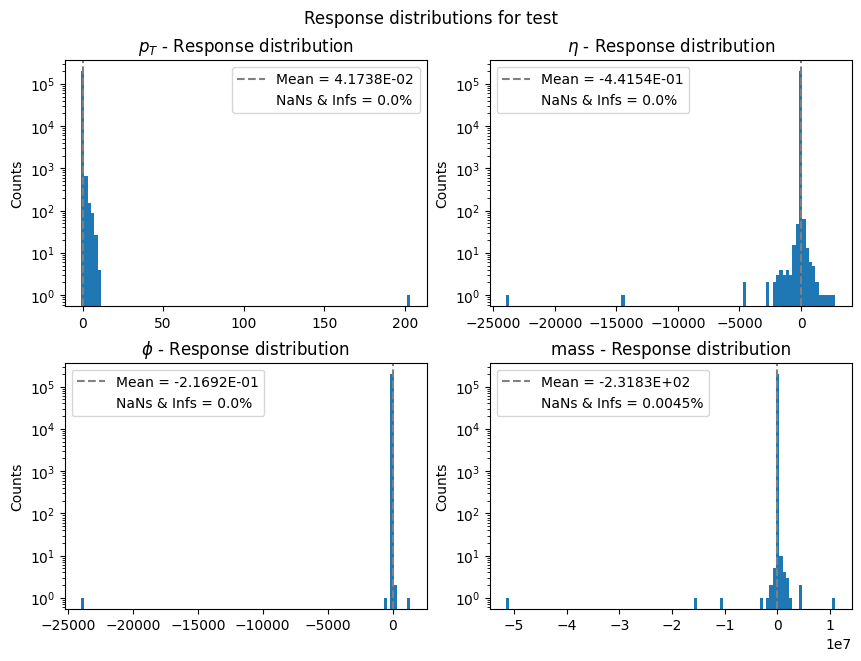

In [ ]:
###TESTING
test_batch_size = 200000
Rtest_txt = []
Rtest_npz = []
size_test_input = []
size_test_compressed = []
size_test_input_npz = []
size_test_compressed_npz = []

for w in range(0, 1000000, test_batch_size):

  xtest = np.copy(xtest_all[w:w+test_batch_size])

  compression_batch_size = 20000
  xtest_compressed= np.zeros(xtest.shape)
  xtest_decompressed= np.zeros(xtest.shape)
  gaus_test= np.zeros(xtest.shape)
  unif_test= np.zeros(xtest.shape)
  gaus_test_post = np.zeros(xtest.shape)

  xtest_preprocessor = Preprocessor(preprocessor_settings)
  xtest_preprocessed = xtest_preprocessor.forward(xtest)

  for t in range(0,len(xtest), compression_batch_size):
    xtest_compressor = Compressor(flow=flow, N=13, limit=3)
    xtest_compressed[t:t+compression_batch_size], gaus_test[t:t+compression_batch_size], unif_test[t:t+compression_batch_size] = xtest_compressor.compress(xtest_preprocessed[t:t+compression_batch_size])
    xtest_decompressed[t:t+compression_batch_size], gaus_test_post[t:t+compression_batch_size] = x_compressor.decompress(xtest_compressed[t:t+compression_batch_size])

  xtest_compressed = xtest_compressed.astype(int)
  xtest_decompressed = xtest_preprocessor.backward(xtest_decompressed)

  with open('test_input.txt', 'w') as test_input:
      for i in range(len(xtest)):
          test_input.write(' '.join(str(xtest[i, j]) for j in range(xtest.shape[1])) + "\n")
  with open('test_compressed.txt', 'w') as test_compressed:
          for i in range(len(xtest)):
              test_compressed.write(' '.join(str(xtest_compressed[i, j]) for j in range(xtest_compressed.shape[1])) + "\n")

  size_test_input.append((stat('test_input.txt').st_size)/(1024*1024))
  size_test_compressed.append((stat('test_compressed.txt').st_size)/(1024*1024))

  np.savez_compressed('test_input.npz', data=xtest)
  np.savez_compressed('test_compressed.npz', data=xtest_compressed)

  size_test_input_npz.append((stat('test_input.npz').st_size)/(1024*1024))
  size_test_compressed_npz.append((stat('test_compressed.npz').st_size)/(1024*1024))

  difference_test = xtest_decompressed-xtest

  fig_diff, axs = plt.subplots(3, 4, figsize=(18, 15), layout='constrained')
  fig_diff.suptitle("Histogram and Ratio Plots for Test")
  n_bins = 100
  for i in range(4):
      y = []
      y.append(xtest[:, i])
      y.append(xtest_decompressed[:, i])

      ns, bins, patches = axs[0, i].hist(y[0], bins=n_bins, label='Original', log=True)
      ns1,bins1,patches1 = axs[0, i].hist(y[1], bins=n_bins, label='Decompressed', histtype='step')
      axs[0, i].set_title('{} [{}]'.format(labels_map[i],unit_measure[i]))
      axs[0, i].set_ylabel("Counts")
      axs[0, i].legend()
      axs[0, i].set_ylim(1e-1,10e4)
      axs[0, i].get_xaxis().set_ticks([])

      axs[1, i].scatter(bins[:-1],ns/ns1)
      axs[1, i].axhline(y=1, color='r', linestyle='--')
      axs[1, i].set_xlabel("Value")
      axs[1, i].set_ylabel("Ratio=Original/Decompressed")
      axs[1, i].set_ylim(-0.5,4.2)


      axs[2, i].hist(difference_test[:, i],bins = n_bins,log=True)
      axs[2, i].set_title("Difference Test")
      axs[2, i].set_ylabel("Counts")
      axs[2, i].axvline(x=np.mean(difference_test[:, i]), color='r', linestyle='--',label='Mean = {:.4f}'.format(np.mean(difference_test[:, i])))
      axs[2, i].legend()

  plt.show()
  fig_diff.savefig('figures/difference_test_model2_N13_{}.pdf'.format(w), dpi=190)


  response_test = np.divide(difference_test,xtest)
  count_test = np.zeros(shape=(4))
  for t in range(0,num_features):
    for y in range(0,len(response_test)):
      if np.isnan(response_test[y][t]) == True:
        count_test[t] +=1
      if np.isinf(response_test[y][t]) == True:
        count_test[t] +=1
        response_test[y][t] = 0
  print('Nans & Infs =', count_test)

  mean_response_test = np.zeros(shape=(4))
  for d in range(0,num_features):
    mean_response_test[d] = np.mean(response_test[:,d])

  fig_response, axs = plt.subplots(2, 2, figsize=(8.5, 6.5), layout='constrained')
  fig_response.suptitle("Response distributions for test")

  axs[0,0].set_title('{} - Response distribution'.format(labels_map[0]))
  axs[0,0].hist(response_test[:,0], bins=n_bins, log=True)
  axs[0,0].set_ylabel("Counts")
  axs[0,0].axvline(x=mean_response_test[0], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response_test[0]))
  axs[0,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count_test[0]*100/len(response_test)))
  axs[0,0].legend()

  axs[0,1].set_title('{} - Response distribution'.format(labels_map[1]))
  axs[0,1].hist(response_test[:,1], bins=n_bins, log=True)
  axs[0,1].set_ylabel("Counts")
  axs[0,1].axvline(x=mean_response_test[1], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response_test[1]))
  axs[0,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count_test[1]*100/len(response_test)))
  axs[0,1].legend()

  axs[1,0].set_title('{} - Response distribution'.format(labels_map[2]))
  axs[1,0].hist(response_test[:,2], bins=n_bins, log=True)
  axs[1,0].set_ylabel("Counts")
  axs[1,0].axvline(x=mean_response_test[2], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response_test[2]))
  axs[1,0].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.3}%'.format(count_test[2]*100/len(response_test)))
  axs[1,0].legend()

  axs[1,1].set_title('{} - Response distribution'.format(labels_map[3]))
  axs[1,1].hist(response_test[:,3], bins=n_bins, log=True)
  axs[1,1].set_ylabel("Counts")
  axs[1,1].axvline(x=mean_response_test[3], color='grey', linestyle='--',label='Mean = {:.4E}'.format(mean_response_test[3]))
  axs[1,1].plot(np.nan,np.nan, ls='', label='NaNs & Infs = {:.2}%'.format(count_test[3]*100/len(response_test)))
  axs[1,1].legend()

  plt.show()
  fig_response.savefig('figures/response_model2_N13_{}.pdf'.format(w), dpi=190)

To calculate the value of the compression ratio R, the file sizes of the input data and the compressed data are stored for these five test datasets. The two formats `.txt` and `.npz` are also used here. <br> Finally, the mean and standard deviation for the compression ratio R is shown.

In [ ]:
print('Size input_test.txt [MB] =',size_test_input)
print('Size compressed_test.txt [MB] =',size_test_compressed)
rtest=np.divide(size_test_input,size_test_compressed)
print('Mean of R_test (.txt) = {:.4} +- {:.2}\n'.format(rtest.mean(),rtest.std()))

print('Size input_test.npz [MB] =',size_test_input_npz)
print('Size compressed_test.npz [MB] =',size_test_compressed_npz)
rtest_npz=np.divide(size_test_input_npz,size_test_compressed_npz)
print('Mean of R_test (.npz) = {:.4} +- {:.2}\n'.format(rtest_npz.mean(),rtest_npz.std()))

Size input_test.txt [MB] = [10.924564361572266, 10.923254013061523, 10.919051170349121, 10.9212064743042, 10.924205780029297]
Size compressed_test.txt [MB] = [4.025142669677734, 4.041949272155762, 4.049501419067383, 4.044716835021973, 4.052543640136719]
Mean of R_test (.txt) = 2.702 +- 0.0067

Size input_test.npz [MB] = [4.54837703704834, 4.547765731811523, 4.542427062988281, 4.544361114501953, 4.548833847045898]
Size compressed_test.npz [MB] = [1.9654302597045898, 1.9703311920166016, 1.971055030822754, 1.9708681106567383, 1.9732942581176758]
Mean of R_test (.npz) = 2.308 +- 0.0035

